# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, AutoConfig, get_scheduler
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from itertools import chain
from copy import deepcopy
from tqdm.notebook import tqdm
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from prettytable import PrettyTable

# Set seeds
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


# Task 1: Dataset Characterization

## Explore the labels

There are 7 unique tags: ['Defense Evasion', 'Discovery', 'Execution', 'Impact', 'Not Malicious Yet', 'Other', 'Persistence']


,Tag,Train Count,Train %,Test Count,Test %
0,Defense Evasion,309,52.37,218,53.36
1,Discovery,6009,28.23,3307,25.30
2,Execution,3239,9.87,1568,11.02
3,Impact,312,2.72,133,3.52
4,Not Malicious Yet,264,2.69,212,3.42
5,Other,209,2.30,76,2.15
6,Persistence,1133,1.82,683,1.23


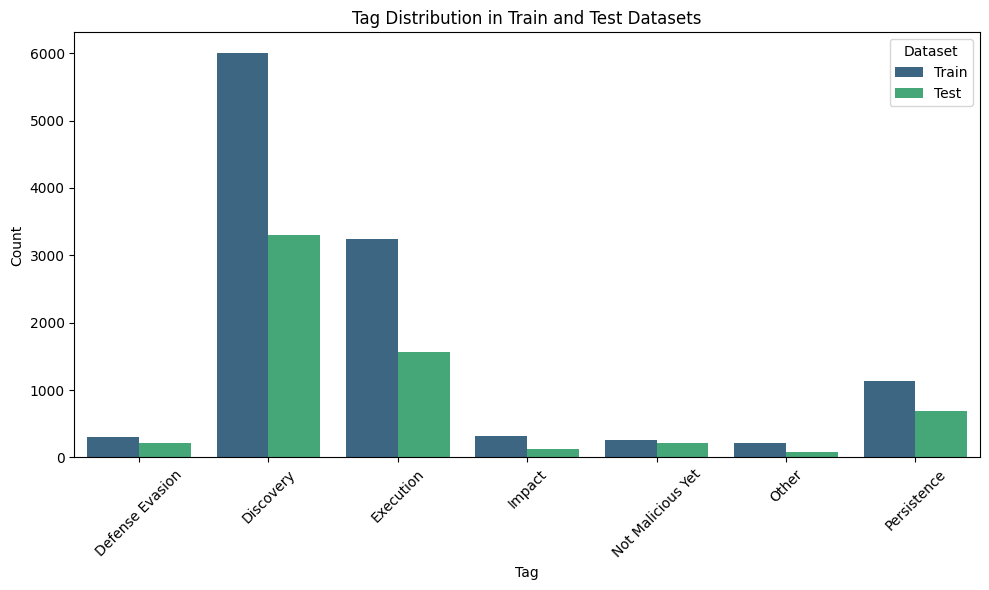

In [ ]:
# Import datasets
train_data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Lab_3/train.json")
test_data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Lab_3/test.json")

# Extract unique tags and sort them in alphabetical ascending order
tags = np.sort(train_data['label'].explode().unique())
print(f"There are {len(tags)} unique tags: {tags.tolist()}")

# Calculate tags numbers for both train and test sets
train_tags_distributions = train_data['label'].explode().value_counts().sort_index()
test_tags_distributions = test_data['label'].explode().value_counts().sort_index()

# Calculate percentages for both train and test sets
train_tag_distributions_percentage = train_data['label'].explode().value_counts(normalize=True) * 100
test_tag_distributions_percentage = test_data['label'].explode().value_counts(normalize=True) * 100

data_table = pd.DataFrame({
    "Tag": train_tags_distributions.index,
    "Train Count": train_tags_distributions.values,
    "Train %": train_tag_distributions_percentage.values.round(2),
    "Test Count": test_tags_distributions.values,
    "Test %": test_tag_distributions_percentage.values.round(2)
})
display(data_table)

# Combine train and test data distributions into a single DataFrame for plotting
plot_data = pd.DataFrame({
    "Tag": np.concatenate([train_tags_distributions.index, test_tags_distributions.index]),
    "Count": np.concatenate([train_tags_distributions.values, test_tags_distributions.values]),
    "Dataset": ["Train"] * len(train_tags_distributions) + ["Test"] * len(test_tags_distributions)
})

# Create a barplot displaying the distribution of tags in Train and Test datasets
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x="Tag", y="Count", hue="Dataset", palette="viridis")
plt.title("Tag Distribution in Train and Test Datasets")
plt.ylabel("Count")
plt.xlabel("Tag")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Explore a single bash command

In [ ]:
train_df = train_data
test_df = test_data

def find_echo_tags(df):
    echo_info_dict = {}
    for _, row in df.iterrows():
        words = row['session'].split()
        for pos, w in enumerate(words):
            if w == 'echo':
                tag = row['label'][pos]
                if tag not in echo_info_dict:
                    echo_info_dict[tag] = {'count': 1, 'example': row['session'], 'pos': pos}
                else:
                    echo_info_dict[tag]['count'] += 1
    return dict(sorted(echo_info_dict.items()))

def print_echo(echo_dict, title):
    print(f"\n{title}")
    print(f"{'TAG':<20} │ {'COUNT':>5} │ {'POS IN EXAMPLE':>3} │ EXAMPLE")
    print("-"*60)
    for tag, info in echo_dict.items():
        print(f"{tag:<20} │ {info['count']:>5} │ {info['pos']:>14} │ {info['example']}")
        #print(f"{tag:<20} │ {info['count']:>5} │ {info['pos']:>14}")

echo_info_train = find_echo_tags(train_df)
echo_info_test  = find_echo_tags(test_df)

print_echo(echo_info_train, "Echo Tags in TRAIN")
print_echo(echo_info_test,  "Echo Tags in TEST")

unique_tags = sorted(set(echo_info_train) | set(echo_info_test))
print(f"\nUnique tags are: {unique_tags}")


Echo Tags in TRAIN
TAG                  │ COUNT │ POS IN EXAMPLE │ EXAMPLE
------------------------------------------------------------
Discovery            │    31 │             11 │ ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/smsd.log /etc/smsd.conf* /usr/bin/qmuxd /var/qmux_connect_socket /etc/config/simman /dev/modem* ; echo Hi | cat -n ;
Execution            │    39 │             17 │ cat /var/tmp/.systemcache436621 ; echo 1 > /var/tmp/.systemcache436621 ; cat /var/tmp/.systemcache436621 ; sleep 15s && cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKcm0gLXJmIC5YMTctdW5peApta2RpciAuWDE3LXVuaXgKY2QgLlgxNy11bml4Cm12IC92YXIvdG1wL2RvdGEudGFyLmd6IGRvdGEudGFyLmd6CnRhciB4ZiBkb3RhLnRhci5negpzbGVlcCAzcyAmJiBjZCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYwpub2h1cCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYy90c20gLXQgMTUwIC1TIDYgLXMgNiAtcCAyMiAtUCAwIC1mIDAgLWsgMSAtbCAxIC1pIDAgL3RtcC91cC50eHQgMTkyLjE2OCA+PiAvZGV2L251bGwgMj4xJgpzbGVlcCA4bSAmJiBub2h1cCAvdG1wL

## Explore the Bash words

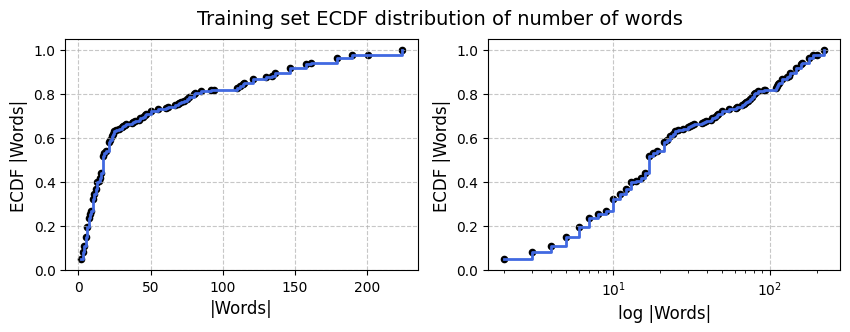

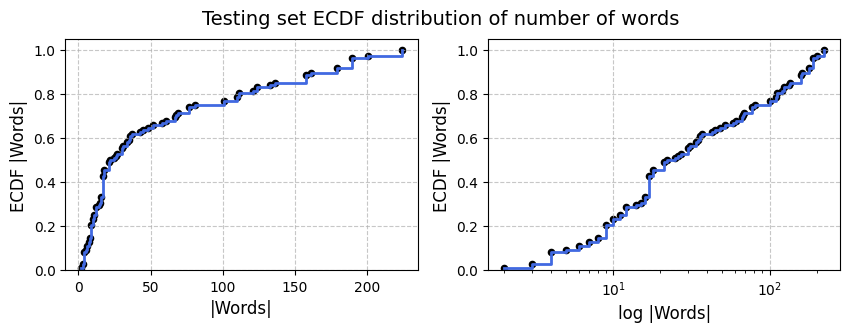

In [ ]:
def get_ecdf(list_numbers):
    counter = Counter(list_numbers)
    values = sorted(counter.keys())
    counts = [counter[value] for value in values]
    # Step 2: Calculate the CDF
    total = sum(counts)
    cumulative_probs = np.cumsum(counts) / total
    return values, cumulative_probs

def plot_ecdf(tokenized_sessions, test_name):
    n_tokens_x_sentence = [len(el) for el in tokenized_sessions]
    n_tokens, cumulative_n_tokens = get_ecdf(n_tokens_x_sentence)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    for ax in axs:
        ax.step(n_tokens, cumulative_n_tokens, where='post', color='royalblue', linewidth=2)
        ax.scatter(n_tokens, cumulative_n_tokens, color='black', s=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel('ECDF |Words|', fontsize=12)
        ax.set_ylim(0, 1.05)
        #ax.axvline(512, 0, 1.05, c="firebrick", label = f"Context size model")
        #ax.legend()

    fig.suptitle(test_name + ' ECDF distribution of number of words', fontsize=14)
    axs[0].set_xlabel('|Words|', fontsize=12)
    axs[1].set_xlabel('log |Words|', fontsize=12)
    axs[1].set_xscale("log")
    plt.show()

split_sessions_train = train_data['session'].str.split(" ")
split_sessions_test = test_data['session'].str.split(" ")
plot_ecdf(split_sessions_train, "Training set")
plot_ecdf(split_sessions_test, "Testing set")

# Task 2: Tokenization

## Loading tokenizers

In [ ]:
bert_model = "google-bert/bert-base-uncased"
unixcoder_model = "microsoft/unixcoder-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model, max_length=512)
unixcoder_tokenizer = AutoTokenizer.from_pretrained(unixcoder_model, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Tokenize the following list of SSH commands: [cat, shell, echo, top, chpasswd, crontab, wget, busybox, grep]

In [ ]:
commands = "cat shell echo top chpasswd crontab wget busybox grep"

## How do tokenizers divide the commands into tokens? Does one of them have a better (lower) ratio between tokens and words?

In [ ]:
def tokenize_and_print_sample_sentence(tokenizer, sentence):
    print(f"Tokenizer: {tokenizer.name_or_path}\n")

    tokenized_sentence = tokenizer(sentence)

    print(f"sample_sentence: {sentence}")
    print(f"tokenized_sentence: {tokenized_sentence}")

    # Extract the input_ids
    in_ids = tokenized_sentence["input_ids"]

    # Convert the input_ids into the corresponding tokens
    tokens = tokenizer.convert_ids_to_tokens(in_ids)

    token_words_ration = len(tokens) / len(sentence.split())

    print(f"\nOriginal sentence (contained {len(sentence.split())} words):\n{sentence}")
    print(f"\nTokenized sentence (contains {len(tokens)} tokens):\n{tokens}")
    print(f"\nRatio between tokens and words: {token_words_ration:.2f}")

In [ ]:
# bert
tokenize_and_print_sample_sentence(bert_tokenizer, commands)

Tokenizer: google-bert/bert-base-uncased

sample_sentence: cat shell echo top chpasswd crontab wget busybox grep
tokenized_sentence: {'input_ids': [101, 4937, 5806, 9052, 2327, 10381, 15194, 21724, 13675, 12162, 7875, 1059, 18150, 5697, 8758, 24665, 13699, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Original sentence (contained 9 words):
cat shell echo top chpasswd crontab wget busybox grep

Tokenized sentence (contains 18 tokens):
['[CLS]', 'cat', 'shell', 'echo', 'top', 'ch', '##pass', '##wd', 'cr', '##ont', '##ab', 'w', '##get', 'busy', '##box', 'gr', '##ep', '[SEP]']

Ratio between tokens and words: 2.00


In [ ]:
# unixcoder
tokenize_and_print_sample_sentence(unixcoder_tokenizer, commands)

Tokenizer: microsoft/unixcoder-base

sample_sentence: cat shell echo top chpasswd crontab wget busybox grep
tokenized_sentence: {'input_ids': [0, 3159, 10171, 5403, 3194, 733, 21073, 404, 6391, 514, 477, 459, 17930, 1849, 36378, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Original sentence (contained 9 words):
cat shell echo top chpasswd crontab wget busybox grep

Tokenized sentence (contains 16 tokens):
['<s>', 'cat', 'Ġshell', 'Ġecho', 'Ġtop', 'Ġch', 'passwd', 'Ġc', 'ront', 'ab', 'Ġw', 'get', 'Ġbusy', 'box', 'Ġgrep', '</s>']

Ratio between tokens and words: 1.78


## ECDF

Token indices sequence length is longer than the specified maximum sequence length for this model (1889 > 512). Running this sequence through the model will result in indexing errors


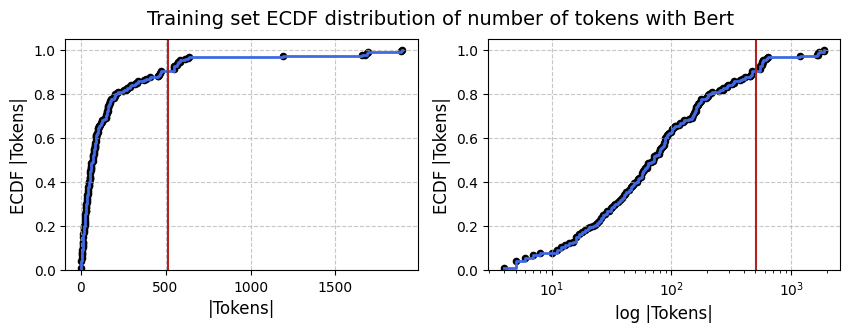

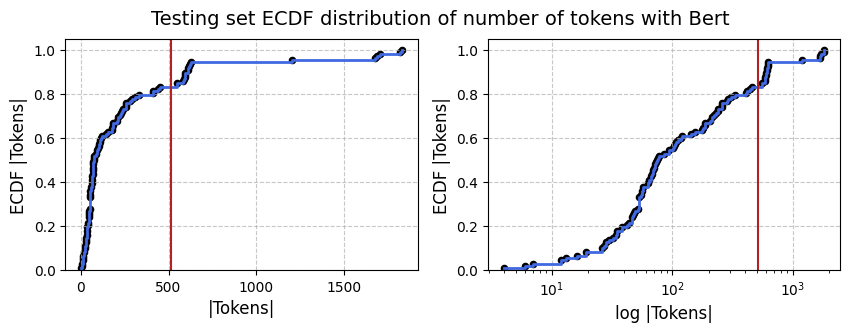

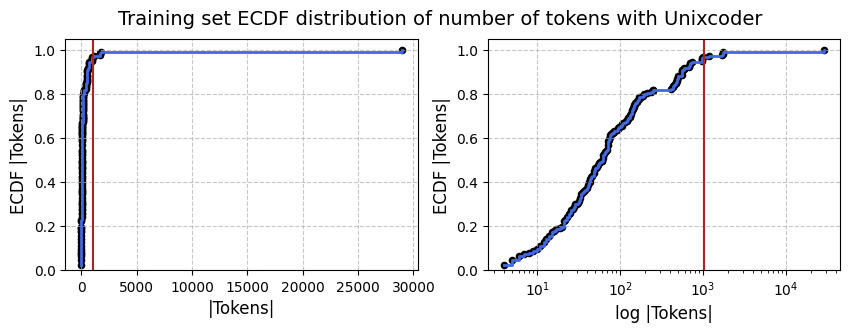

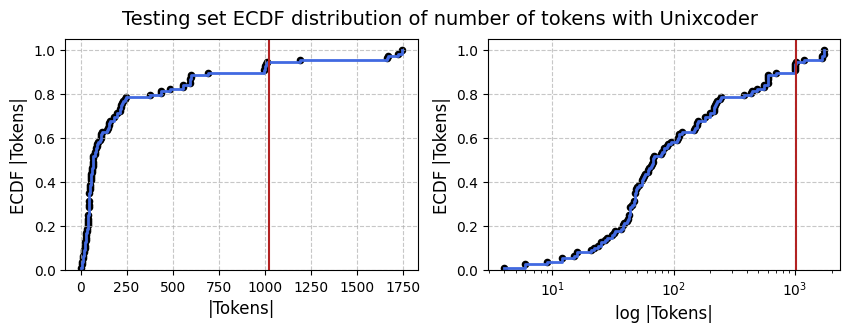

In [ ]:
def tokenize_data(tokenizer, data):
    tokenized_list = [tokenizer(element) for element in data]
    return tokenized_list

bert_tokenized_train_list = tokenize_data(bert_tokenizer, train_data['session'])
bert_tokenized_test_list = tokenize_data(bert_tokenizer, test_data['session'])
unixcoder_tokenized_train_list = tokenize_data(unixcoder_tokenizer, train_data['session'])
unixcoder_tokenized_test_list = tokenize_data(unixcoder_tokenizer, test_data['session'])

def plot_ecdf(tokenized_sessions_ids, test_name, type_of_tokenizer):
    n_tokens_x_sentence = [len(el) for el in tokenized_sessions_ids]
    n_tokens, cumulative_n_tokens = get_ecdf(n_tokens_x_sentence)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    for ax in axs:
        ax.step(n_tokens, cumulative_n_tokens, where='post', color='royalblue', linewidth=2)
        ax.scatter(n_tokens, cumulative_n_tokens, color='black', s=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel('ECDF |Tokens|', fontsize=12)
        ax.set_ylim(0, 1.05)
        if (type_of_tokenizer == "Unixcoder"):
            ax.axvline(1024, 0, 1.05, c="firebrick", label = f"Context size model")
        elif (type_of_tokenizer == "Bert"):
            ax.axvline(512, 0, 1.05, c="firebrick", label = f"Context size model")
        #ax.legend()

    fig.suptitle(test_name + ' ECDF distribution of number of tokens with ' + type_of_tokenizer, fontsize=14)
    axs[0].set_xlabel('|Tokens|', fontsize=12)
    axs[1].set_xlabel('log |Tokens|', fontsize=12)
    axs[1].set_xscale("log")
    plt.show()

plot_ecdf([tokenized_el['input_ids'] for tokenized_el in bert_tokenized_train_list], "Training set", "Bert")
plot_ecdf([tokenized_el['input_ids'] for tokenized_el in bert_tokenized_test_list], "Testing set", "Bert")
plot_ecdf([tokenized_el['input_ids'] for tokenized_el in unixcoder_tokenized_train_list], "Training set", "Unixcoder")
plot_ecdf([tokenized_el['input_ids'] for tokenized_el in unixcoder_tokenized_test_list], "Testing set", "Unixcoder")

## Now tokenize the entire training corpus with both tokenizers

### How many tokens does the BERT and Unixcoder tokenizer generate on average?

In [ ]:
def tokenize_data_table(tokenizer, data):
    tokenized_list = [tokenizer(element) for element in data]

    token_lengths = []  # List to track the number of tokens for each sentence

    for tokenized in tokenized_list:
        # Append token count for the sentence
        token_lengths.append(len(tokenized['input_ids']))

    # Calculate the mean and max number of tokens
    mean_tokens = np.mean(token_lengths)
    max_tokens = max(token_lengths)
    return {
        "Tokenizer": tokenizer.name_or_path,
        "Mean Tokens": mean_tokens,
        "Max Tokens": max_tokens
    }

results = []

# Process each dataset with each tokenizer
results.append(tokenize_data_table(bert_tokenizer, [item for item in train_data['session']]))
results.append(tokenize_data_table(unixcoder_tokenizer, [item for item in train_data['session']]))

# Add dataset information to results
results[0]["Dataset"] = "Train Set"
results[1]["Dataset"] = "Train Set"

# Convert results into a DataFrame for displaying as a table
results_df = pd.DataFrame(results, columns=["Tokenizer", "Mean Tokens", "Max Tokens", "Dataset"])
print(results_df)

                       Tokenizer  Mean Tokens  Max Tokens    Dataset
0  google-bert/bert-base-uncased   178.585657        1889  Train Set
1       microsoft/unixcoder-base   409.266932       28920  Train Set


### What is the maximum number of tokens per bash session for both tokenizers? How many sessions would currently be truncated for each tokenizer

In [ ]:
# Tokenizing the session
bert_tokenized_train = train_data.copy()
unixcoder_tokenized_train = train_data.copy()

for i in range(len(bert_tokenized_train)):
    bert_tokenized_train['session'][i] = bert_tokenizer(bert_tokenized_train['session'][i])

for i in range(len(unixcoder_tokenized_train)):
    unixcoder_tokenized_train['session'][i] = unixcoder_tokenizer(unixcoder_tokenized_train['session'][i])

/tmp/ipython-input-13-3973025040.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bert_tokenized_train['session'][i] = bert_tokenizer(bert_tokenized_train['session'][i])
/tmp/ipython-input-13-3973025040.py:9: FutureWarning: ChainedAssignm

In [ ]:
# Max number of tokens per bash session
max_tokens_per_session_bert = 0
max_tokens_per_session_unixcoder = 0
max_tokens_session_bert_idx = 0
max_tokens_session_unixcoder_idx = 0

bert_maximum_context = bert_tokenizer.model_max_length
unixcoder_maximum_context = 1024 # the value in mode_max_length is wrong

bert_num_truncated_sessions = 0
unixcoder_num_truncated_sessions = 0

for idx, tokenized_session in enumerate(bert_tokenized_train['session']):
    if len(tokenized_session['input_ids']) > max_tokens_per_session_bert:
        max_tokens_per_session_bert = len(tokenized_session['input_ids'])
        max_tokens_session_bert_idx = idx
    if len(tokenized_session['input_ids']) > bert_maximum_context:
        bert_num_truncated_sessions += 1

for idx, tokenized_session in enumerate(unixcoder_tokenized_train['session']):
    if len(tokenized_session['input_ids']) > max_tokens_per_session_unixcoder:
        max_tokens_per_session_unixcoder = len(tokenized_session['input_ids'])
        max_tokens_session_unixcoder_idx = idx
    if len(tokenized_session['input_ids']) > unixcoder_maximum_context:
        unixcoder_num_truncated_sessions += 1

print(f"Bert context size: {bert_maximum_context}")
print(f"Unixcoder context size: {unixcoder_maximum_context}")
print(f"Max number of tokens per bash session for BERT: {max_tokens_per_session_bert}")
print(f"Max number of tokens per bash session for Unixcoder: {max_tokens_per_session_unixcoder}")
print(f"Number of truncated sessions for BERT: {bert_num_truncated_sessions}")
print(f"Number of truncated sessions for Unixcoder: {unixcoder_num_truncated_sessions}")
print(f"Index of the longest truncated session for BERT: {max_tokens_session_bert_idx}")
print(f"Index of the longest truncated session for Unixcoder: {max_tokens_session_unixcoder_idx}")

Bert context size: 512
Unixcoder context size: 1024
Max number of tokens per bash session for BERT: 1889
Max number of tokens per bash session for Unixcoder: 28920
Number of truncated sessions for BERT: 24
Number of truncated sessions for Unixcoder: 8
Index of the longest truncated session for BERT: 14
Index of the longest truncated session for Unixcoder: 14


###  Select the bash session that corresponds to the maximum number of tokens. How many bash words does it contain?

In [ ]:
words_number = len(train_data['session'][max_tokens_session_unixcoder_idx].split())
print(f"The longest tokenized session contains {words_number} words:\n {(train_data['session'][max_tokens_session_unixcoder_idx])}")

The longest tokenized session contains 134 words:
 cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB1bnBhY2sgdT0+cXtfIkZVWSgiMVA8Rl1DOTctUztSYF0oIj1SPFdFTjhSPFsiQEhEPFY1Uj1GRUQ7VyhdKVMkVC1CWFEuIzROLDM8UStDKFItUjxAPTZZTDk3LVMoIjFTXzk3KVY6NjFPPENMKjs3REApJyFPPEcxQS8yPFQtIyxHLlBJTT4yIWA4ViVOODZFUy8yQEIoVyFQKEJEWyJGVVkoJCFBOSZVUy8yQEIwMihMKEVAQl8qM0wqOzdEQDAmJVU9JkBdKiIpTDtWLUE7JkFPPFcwQiozTCoiRlVZKCIxTDo2WUE8VV1NODdAXS1DTCo7N0RAKSctTDk2NVAvMyxbIkBJTT4yYERfO0ZFQzpSYF0oJj1FPSZZSThWTEgqM0wqOzdEQCkmRVI4VllBOzY0QC8yIUc5NzFOOjYtSyoiRFsiRlVZKCIxUjk2JUw7RiVNOTJgXSgiQUA9NllBXzs2NEArNiVAKjNMKiJGVVkoIjFBOFY1UzxWXVM6JjVMOyJgXSgjJFsiRlVZKCIxUDxGNUY6N0FPKCNUQChCJEAoQ0wqOzdEQCkmNVM9JiVUOjctVF86Ni1BPFJgXSgjYFsiRlVZKCIxUDg2LU89JjVTKCNUQCwzTCoiRlVZKCIxNjE1KTMwNFxALzJgRywiWFI4MjxbIkBIRDRURSc+Uj0pM0UwRz8yYF1fKCI9KTFUWS80RDRHLlBIRDRURSc+Uj0oNTVgRz8yYF0oIj0pMVRZLzRENEcuUEhENFRFJz5SPTQxNSktKVdUQC8yYEcyND0uM1UpJSlTTCopJS0pXzFXTEcwVEEsMSI9XSgjVEApVEUnM0RdMjEyPFsiQjEzMjQ9WylVITMpV1RALzJgRzI0PS4zVSklKVNMKiJHNVM5MiEpM1

In [ ]:
input_ids = bert_tokenized_train['session'][max_tokens_session_bert_idx]['input_ids']
print(f"Longest BERT tokenized session ({len(bert_tokenizer.convert_ids_to_tokens(input_ids))} tokens):\n {bert_tokenizer.convert_ids_to_tokens(input_ids)}")

Longest BERT tokenized session (1889 tokens):
 ['[CLS]', 'cd', '/', 't', '##mp', '|', '|', '/', 'var', '/', 't', '##mp', '|', '|', '/', 'dev', '/', 'sh', '##m', ';', 'echo', 'z', '##x', '##zh', '##bc', '##b', '##1', '##bn', '##bh', '##y', '##2', '##sg', '##dt', '##0', '+', '[UNK]', '+', 'u', '##j', '##0', '##pm', '##0', '##uw', '##rz', '##8', '##y', '##y', '##f', '##1', '##fk', '##ci', '##9', '##kt', '##fu', '##ws', '##80', '##rd', '##rh', '##ll', '##bird', '##ru', '##rs', '##c', '+', '[UNK]', '/', '[UNK]', '/', '[UNK]', '+', '[UNK]', '/', '[UNK]', '/', '[UNK]', '+', 'j', '##0', '##rc', '##k', '##j', '##j', '##gr', '##il', '##cy', '##eg', '##p', '##j', '##y', '##fs', '##o', '##1', '##db', '##ws', '##g', '##j', '##ve', '##ap', '##j', '##du', '##un', '##ud', '##m', '##rd', '##d', '##x', '##ve', '##k', '/', 'mi', '##fl', '##ot', '##df', '##uy', '##gins', '##uz', '##rth', '##bi', '##k', '##j', '##g', '##q', '##do', '##2', '##oe', '##aq', '##ik', '##be', '##x', '##z', '##wn', '##ku', '##8',

In [ ]:
input_ids = unixcoder_tokenized_train['session'][max_tokens_session_unixcoder_idx]['input_ids']
print(f"Longest Unixcoder tokenized session ({len(unixcoder_tokenizer.convert_ids_to_tokens(input_ids))} tokens): \n{unixcoder_tokenizer.convert_ids_to_tokens(input_ids)}")

Longest Unixcoder tokenized session (28920 tokens): 
['<s>', 'cd', 'Ġ/', 'tmp', 'Ġ||', 'Ġ/', 'var', '/', 'tmp', 'Ġ||', 'Ġ/', 'dev', '/', 'shm', 'Ġ;', 'Ġecho', 'ĠZ', 'XZ', 'hb', 'CB', '1', 'bn', 'B', 'hY', '2', 'sg', 'dT', '0', '+', 'cX', 'tf', 'Ik', 'ZV', 'WS', 'gi', 'MV', 'A', '8', 'Rl', '1', 'DOT', 'ct', 'U', 'zt', 'SY', 'F', '0', 'o', 'Ij', '1', 'SP', 'Fd', 'FT', 'jh', 'SP', 'F', 'si', 'QE', 'h', 'EP', 'FY', '1', 'Uj', '1', 'GR', 'UQ', '7', 'Vy', 'hd', 'K', 'VM', 'k', 'VC', '1', 'CW', 'FE', 'u', 'Iz', 'R', 'OL', 'DM', '8', 'U', 'St', 'DK', 'FI', 't', 'Uj', 'x', 'AP', 'T', 'ZZ', 'TD', 'k', '3', 'LV', 'Mo', 'Ij', 'F', 'TX', 'zk', '3', 'KV', 'Y', '6', 'Nj', 'FP', 'PEN', 'MK', 'js', '3', 'RE', 'Ap', 'Jy', 'FP', 'PE', 'cx', 'QS', '8', 'y', 'PF', 'Qt', 'I', 'yx', 'HL', 'l', 'BJ', 'TT', '4', 'y', 'I', 'WA', '4', 'Vi', 'VO', 'OD', 'Z', 'FU', 'y', '8', 'y', 'QE', 'Io', 'Vy', 'FQ', 'KE', 'J', 'EW', 'y', 'J', 'GV', 'Vk', 'o', 'J', 'CF', 'BO', 'SZ', 'VU', 'y', '8', 'y', 'QE', 'Iw', 'M', 'ih', '

In [ ]:
len(unixcoder_tokenizer.convert_ids_to_tokens(input_ids))

28920

### Truncate words longer than 30 characters. Re-tokenize the processed sessions. How many tokens per session do you have with the two tokenizers?

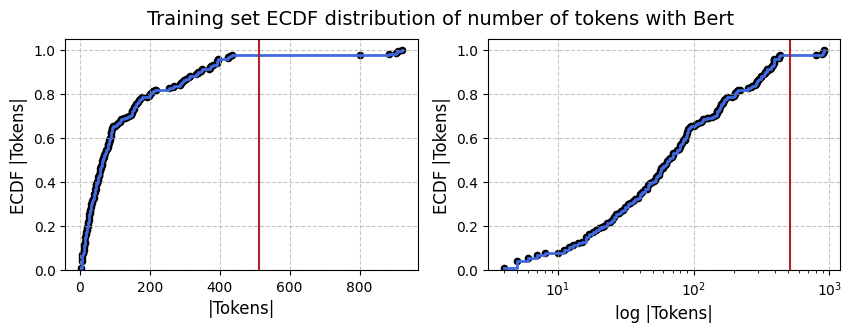

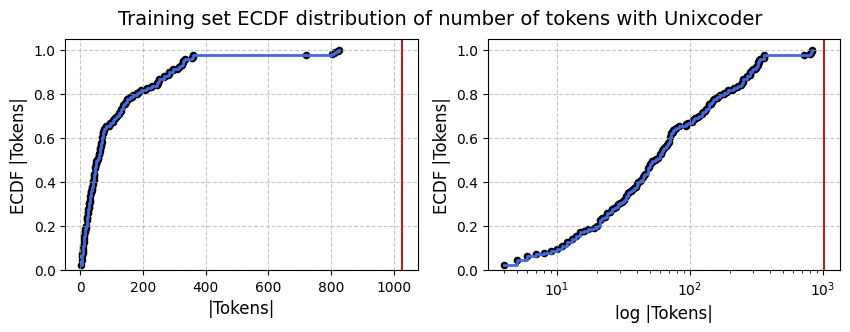

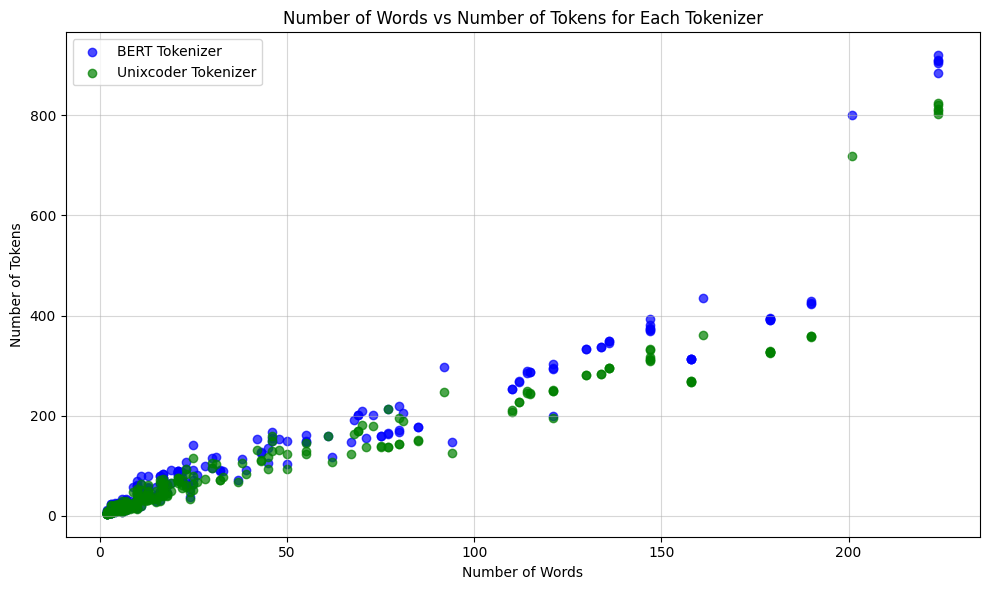

Number of truncated sessions for BERT: 6
Number of truncated sessions for Unixcoder: 0


In [ ]:
def truncate_sessions(data, max_length):
    truncated_data = []
    for session in data['session']:
        truncated_session = ""
        for word in session.split():
            truncated_session += word[:max_length] + " "
        truncated_data.append(truncated_session.strip())
    return truncated_data

train_data_truncated_list = truncate_sessions(train_data, 30)

bert_tokenized_truncated = [bert_tokenizer(session) for session in train_data_truncated_list]
unixcoder_tokenized_truncated = [unixcoder_tokenizer(session) for session in train_data_truncated_list]

plot_ecdf([tokenized_session['input_ids'] for tokenized_session in bert_tokenized_truncated], "Training set", "Bert")
plot_ecdf([tokenized_session['input_ids'] for tokenized_session in unixcoder_tokenized_truncated], "Training set", "Unixcoder")

bert_token_truncated_session_lengths = []
unixcoder_token_truncated_session_lengths = []
word_truncated_session_number = []

for session in bert_tokenized_truncated:
    bert_token_truncated_session_lengths.append(len(session['input_ids']))

for session in unixcoder_tokenized_truncated:
    unixcoder_token_truncated_session_lengths.append(len(session['input_ids']))

for session in train_data_truncated_list:
    word_truncated_session_number.append(len(session.split()))

# Create a scatter plot of the number of words vs number of tokens for each tokenizer
plt.figure(figsize=(10, 6))
plt.scatter(word_truncated_session_number, bert_token_truncated_session_lengths, label="BERT Tokenizer", alpha=0.7, c='blue')
plt.scatter(word_truncated_session_number, unixcoder_token_truncated_session_lengths, label="Unixcoder Tokenizer", alpha=0.7, c='green')

# Add plot labels and title
plt.title("Number of Words vs Number of Tokens for Each Tokenizer")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

bert_num_truncated_sessions = 0
unixcoder_num_truncated_sessions = 0

for tokenized_session in bert_tokenized_truncated:
    if len(tokenized_session['input_ids']) > bert_maximum_context:
        bert_num_truncated_sessions += 1

for tokenized_session in unixcoder_tokenized_truncated:
    if len(tokenized_session['input_ids']) > unixcoder_maximum_context:
        unixcoder_num_truncated_sessions += 1

print(f"Number of truncated sessions for BERT: {bert_num_truncated_sessions}")
print(f"Number of truncated sessions for Unixcoder: {unixcoder_num_truncated_sessions}")

# Task 3: Model Training

## Generating training and validation set and label encoding

In [ ]:
# Import datasets
train_data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Lab_3/train.json")
test_data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Lab_3/test.json")

# Truncate the words to 30 character to avoid generate more tokens than the context size of bert
train_truncated = pd.DataFrame({
    "session": [" ".join(word[:30] for word in session.split(" ")) for session in train_data['session']],
    "label": train_data['label']
})

# Truncate the words to 30 character to avoid generate more tokens than the context size of bert
test_data = pd.DataFrame({
    "session": [" ".join(word[:30] for word in session.split(" ")) for session in test_data['session']],
    "label": test_data['label']
})

train_data, val_data = train_test_split(train_truncated, test_size=0.2, random_state=69)  # 80% of the data is used for training

# Convert the DataFrames into huggingface Datasets and grouping the partitions
full_data = DatasetDict(
    {
        "train": Dataset.from_pandas(train_data.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_data.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_data.reset_index(drop=True))
    }
)

# Extract the labels
unique_labels = list(train_data.label.explode().unique())

# Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Map the label into numeric identifiers
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample

# Apply the mapping function to all splits of your dataset
encoded_data = full_data.map(convert_labels_to_ids)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

## Loading tokenizers

In [ ]:
bert_model = "google-bert/bert-base-uncased"
unixcoder_model = "microsoft/unixcoder-base"
secureShell_model = "SmartDataPolito/SecureShellBert"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model, max_length=512, add_prefix_space=True)
unixcoder_tokenizer = AutoTokenizer.from_pretrained(unixcoder_model, max_length=512, add_prefix_space=True)
secureShell_tokenizer = AutoTokenizer.from_pretrained(secureShell_model, max_length=512, add_prefix_space=True)

## Tokenize and align labels

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text.

    This function maps word-level labels to their corresponding tokens after tokenization.
    It handles special tokens (with None word_ids) and subword tokens (multiple tokens for one word).
    Args:
       labels (list): Original word-level labels.
       word_ids (list): List of word indices that each token corresponds to.
                        None values represent special tokens.
    Returns:
       list: New token-aligned labels where:
            - Special tokens (None word_ids) are assigned -100
            - First token of each word gets the word's label
            - Continuation tokens of the same word also get the word's label
    Example:
       labels = [0, 1, 2]  # Labels for 3 words
       word_ids = [None, 0, 0, 1, 2, 2, None]  # Tokenized into 7 tokens
       result = [-100, 0, 0, 1, 2, 2, -100]  # Aligned labels
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples, tokenizer):
    """Tokenizes text examples and aligns their labels with the resulting tokens.
    This function processes a batch of examples by:
    1. Tokenizing the text in 'sentences' field
    2. Converting word-level labels to token-level labels for each example
    3. Adding the aligned labels back to the tokenized inputs
    Args:
       examples (dict): Dictionary containing:
           - 'sentences': List of text sentences
           - 'label_id': List of lists containing word-level tags for each command
    Returns:
       dict: Tokenized inputs with aligned labels:
           - Standard tokenizer outputs (input_ids, attention_mask, etc.)
           - 'labels': Token-level labels aligned with the tokenized inputs
    Notes:
       - Uses a pre-defined tokenizer (must be available in scope)
       - Sets is_split_into_words=True because input is already word-tokenized
       - Uses align_labels_with_tokens helper function to handle subword tokenization
    """
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True,  # Input is already split into words
        max_length=512
    )
    # Extract all label_id lists from the examples
    all_ids = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, labels in enumerate(all_ids):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(labels, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

original_columns = encoded_data["train"].column_names


tokenized_datasets_bert = encoded_data.map(
    lambda samples: tokenize_and_align_labels(samples, bert_tokenizer),
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

tokenized_datasets_unixcoder = encoded_data.map(
    lambda samples: tokenize_and_align_labels(samples, unixcoder_tokenizer),
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

tokenized_datasets_secureShell = encoded_data.map(
    lambda samples: tokenize_and_align_labels(samples, secureShell_tokenizer),
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

## Padding input_ids and labels to have the same number of column for each element of the batches


In [ ]:
data_collator_bert = DataCollatorForTokenClassification(tokenizer=bert_tokenizer)
data_collator_unixcoder = DataCollatorForTokenClassification(tokenizer=unixcoder_tokenizer)
data_collator_secureShell = DataCollatorForTokenClassification(tokenizer=secureShell_tokenizer)

## Defining postprocessing, metrics, stats plots, confusion matrix

In [ ]:
# The model is going to classify all tokens so we need a function to post-process and gather the predictions
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]:
            A tuple containing two lists:
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
            - `true_labels`: The list of true label sequences with special tokens removed.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

# Define metrics
def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()

def plot_f1_score_per_label(full_labels, full_predictions):
    mlb = MultiLabelBinarizer()
    full_labels_binarized = mlb.fit_transform(full_labels)
    full_predictions_binarized = mlb.transform(full_predictions)

    report = classification_report(full_labels_binarized, full_predictions_binarized, target_names=mlb.classes_, output_dict=True)

    labels = mlb.classes_  # Use classes from binarizer
    f1_scores = [report[label]["f1-score"] for label in labels]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, f1_scores, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("F1-Score")
    plt.xlabel("Class")
    plt.title("Per Class F1-Score")
    plt.tight_layout()
    plt.show()

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

## Fine-tuning bert model

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_bert["train"], shuffle=True, collate_fn=data_collator_bert, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_bert["valid"], collate_fn=data_collator_bert, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_bert["test"], collate_fn=data_collator_bert, batch_size=16)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path="google-bert/bert-base-uncased", id2label=id2label, label2id=label2id).to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.542273273674369, 'token_f1': 0.16969051364039814}
epoch 1: {'token_accuracy': 0.7048216909309469, 'token_f1': 0.28202153203210667}
epoch 2: {'token_accuracy': 0.7626552691331642, 'token_f1': 0.3354342513260936}
epoch 3: {'token_accuracy': 0.7900360625083478, 'token_f1': 0.3540479321456807}
epoch 4: {'token_accuracy': 0.7927073594229999, 'token_f1': 0.3557995606892619}
epoch 5: {'token_accuracy': 0.8334446373714438, 'token_f1': 0.3724368075095597}
epoch 6: {'token_accuracy': 0.8334446373714438, 'token_f1': 0.37488054438612345}
epoch 7: {'token_accuracy': 0.8680379324161881, 'token_f1': 0.45547185829007664}
epoch 8: {'token_accuracy': 0.8791238146119941, 'token_f1': 0.5646481465558465}
epoch 9: {'token_accuracy': 0.899024976626152, 'token_f1': 0.620600958760205}
epoch 10: {'token_accuracy': 0.8879390944303459, 'token_f1': 0.6201840373170989}
epoch 11: {'token_accuracy': 0.8948844664084413, 'token_f1': 0.6225514295026348}
epoch 12: {'token_accuracy': 0.897822

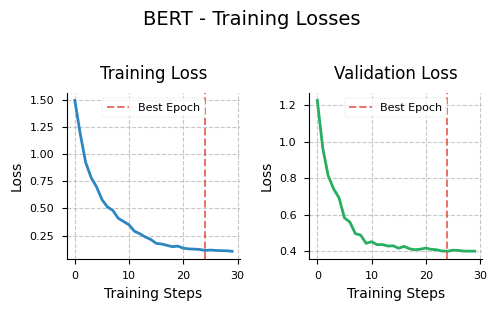

In [ ]:
learning_rate = 1e-5
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 10
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("BERT", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

### Testing

Average session fidelity: 0.80
token_accuracy      :  82.25%
token_f1            :  51.53%
token_precision     :  81.01%
token_recall        :  47.74%


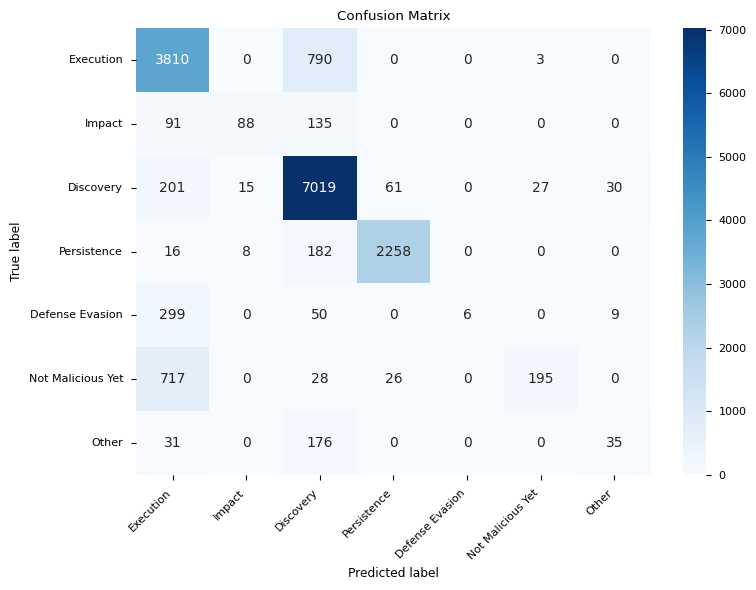

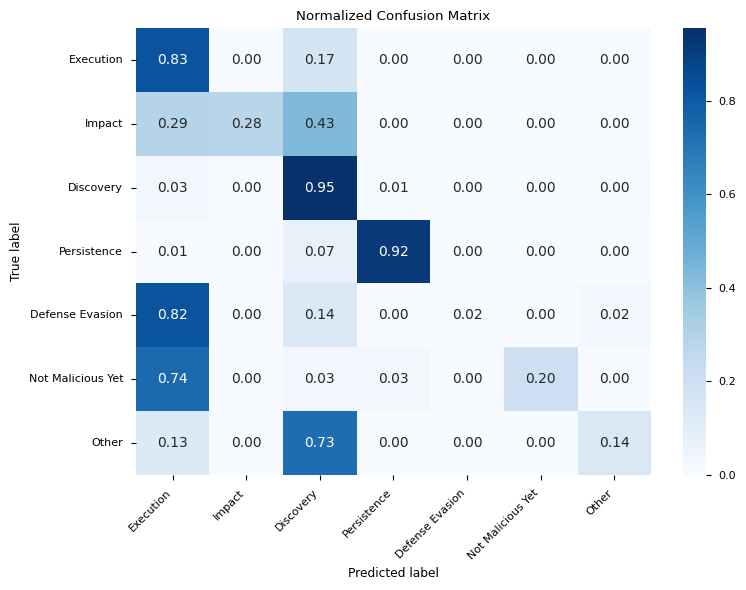

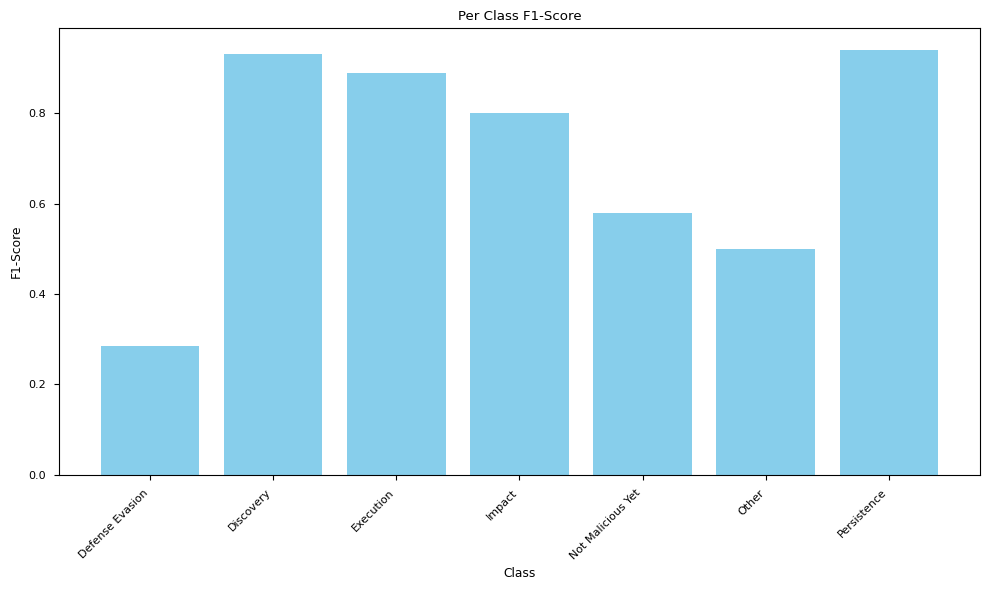

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

## Naked bert model

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_bert["train"], shuffle=True, collate_fn=data_collator_bert, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_bert["valid"], collate_fn=data_collator_bert, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_bert["test"], collate_fn=data_collator_bert, batch_size=16)

config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path="google-bert/bert-base-uncased",
    id2label=id2label, # Notice that we are also providing the mapping from ids to labels
    label2id=label2id, # And viceversa
)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_config(config).to(device)

### Training

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5143582209162548, 'token_f1': 0.15361196844119474}
epoch 1: {'token_accuracy': 0.6500601041805797, 'token_f1': 0.2196353373152964}
epoch 2: {'token_accuracy': 0.7052223854681448, 'token_f1': 0.28016132503999824}
epoch 3: {'token_accuracy': 0.6789101108588219, 'token_f1': 0.2699421939898358}
epoch 4: {'token_accuracy': 0.6889274742887672, 'token_f1': 0.28176055009113216}
epoch 5: {'token_accuracy': 0.7326031788433285, 'token_f1': 0.3114031710434449}
epoch 6: {'token_accuracy': 0.7374115132897021, 'token_f1': 0.30652136487029064}
epoch 7: {'token_accuracy': 0.7639909175904902, 'token_f1': 0.3789690267298343}
epoch 8: {'token_accuracy': 0.7609189261386403, 'token_f1': 0.34427750214357405}
epoch 9: {'token_accuracy': 0.7854948577534393, 'token_f1': 0.4210631572695552}
epoch 10: {'token_accuracy': 0.7850941632162415, 'token_f1': 0.4127432946738486}
epoch 11: {'token_accuracy': 0.7915052758114064, 'token_f1': 0.4697368232022629}
epoch 12: {'token_accuracy': 0.79

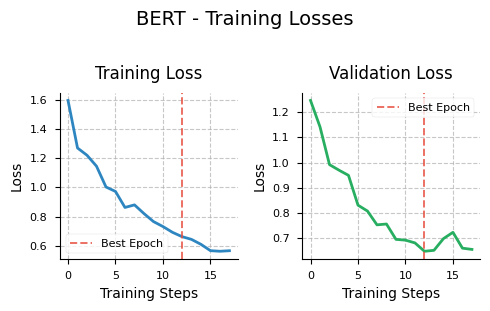

In [ ]:
learning_rate = 1e-5
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 10
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("BERT", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

### Testing

Average session fidelity: 0.71
token_accuracy      :  72.49%
token_f1            :  39.40%
token_precision     :  54.01%
token_recall        :  38.05%


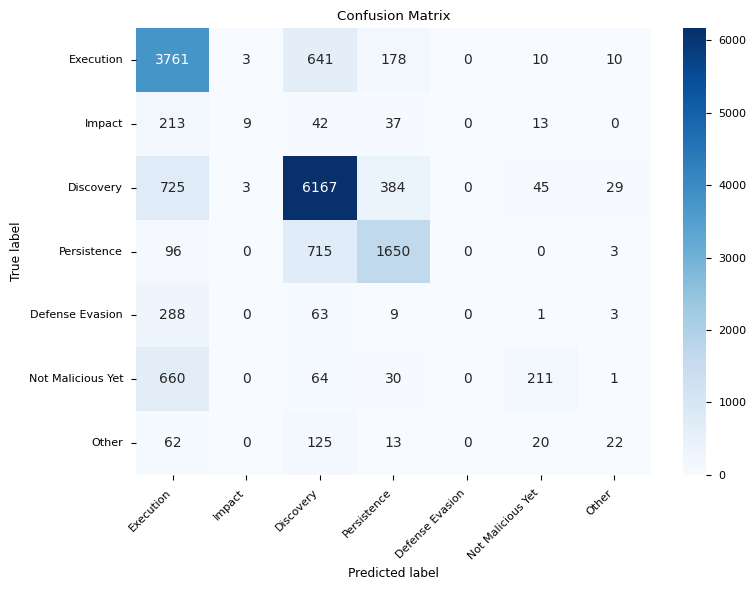

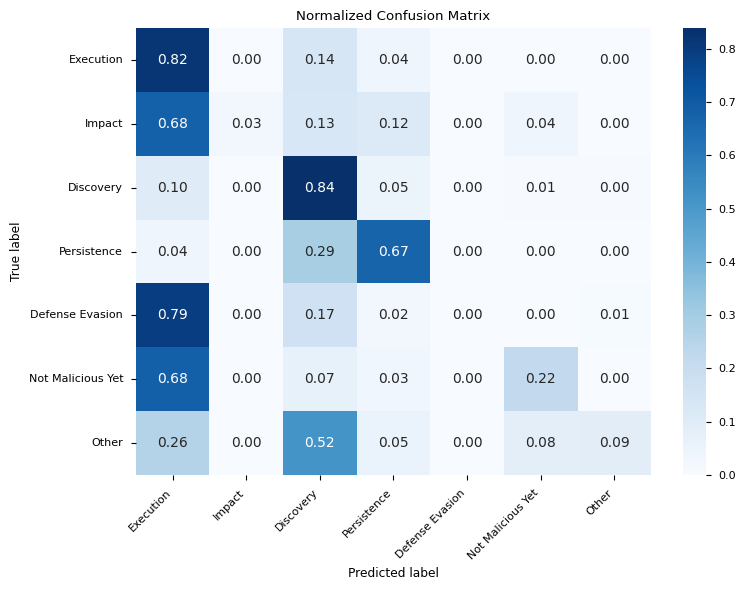

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


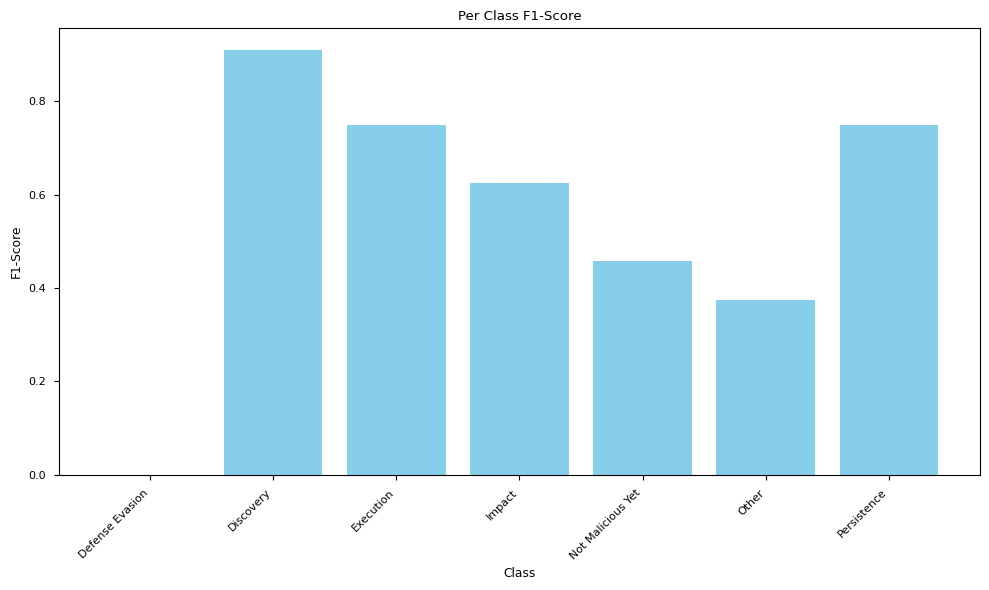

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

## Fine-tuning unixcoder model

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_unixcoder["train"], shuffle=True, collate_fn=data_collator_unixcoder, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_unixcoder["valid"], collate_fn=data_collator_unixcoder, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_unixcoder["test"], collate_fn=data_collator_unixcoder, batch_size=16)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path="microsoft/unixcoder-base", id2label=id2label, label2id=label2id).to(device)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6766237745098039, 'token_f1': 0.22714796890415842}
epoch 1: {'token_accuracy': 0.7089460784313726, 'token_f1': 0.262975156742745}
epoch 2: {'token_accuracy': 0.7795649509803921, 'token_f1': 0.35394803263834}
epoch 3: {'token_accuracy': 0.8023897058823529, 'token_f1': 0.4249671340454638}
epoch 4: {'token_accuracy': 0.8353247549019608, 'token_f1': 0.4604559207002176}
epoch 5: {'token_accuracy': 0.8501838235294118, 'token_f1': 0.48251575216007364}
epoch 6: {'token_accuracy': 0.8635110294117647, 'token_f1': 0.49445767128489343}
epoch 7: {'token_accuracy': 0.8814338235294118, 'token_f1': 0.6084171576835397}
epoch 8: {'token_accuracy': 0.8834252450980392, 'token_f1': 0.5373701178212392}
epoch 9: {'token_accuracy': 0.9015012254901961, 'token_f1': 0.712718920732214}
epoch 10: {'token_accuracy': 0.9079350490196079, 'token_f1': 0.7392626737806495}
epoch 11: {'token_accuracy': 0.9149816176470589, 'token_f1': 0.7600566686408851}
epoch 12: {'token_accuracy': 0.91681985

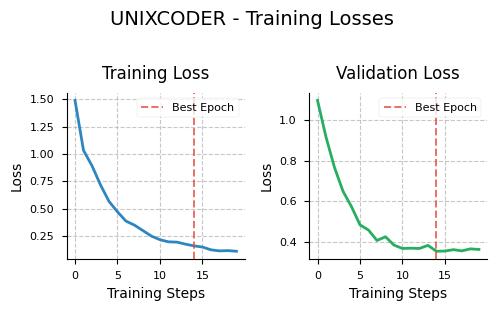

In [ ]:
learning_rate = 1e-5
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 10
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("UNIXCODER", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

### Testing

Average session fidelity: 0.82
token_accuracy      :  85.35%
token_f1            :  62.48%
token_precision     :  75.84%
token_recall        :  57.81%


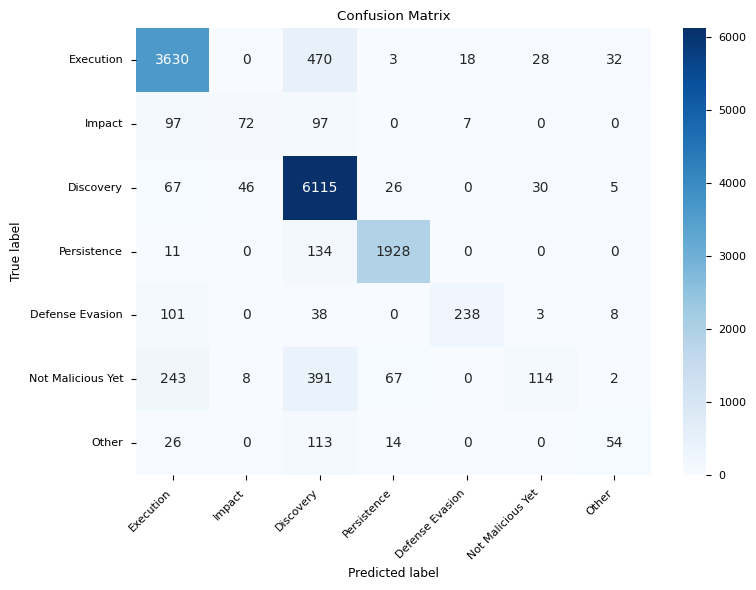

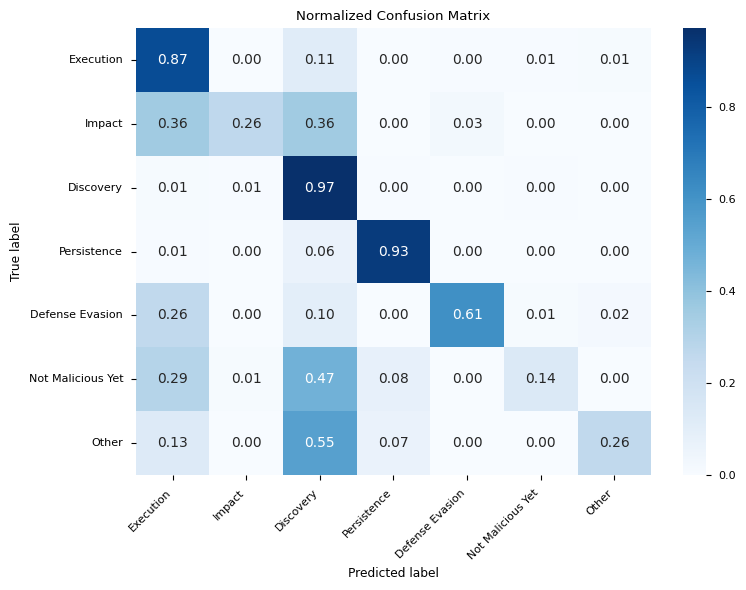

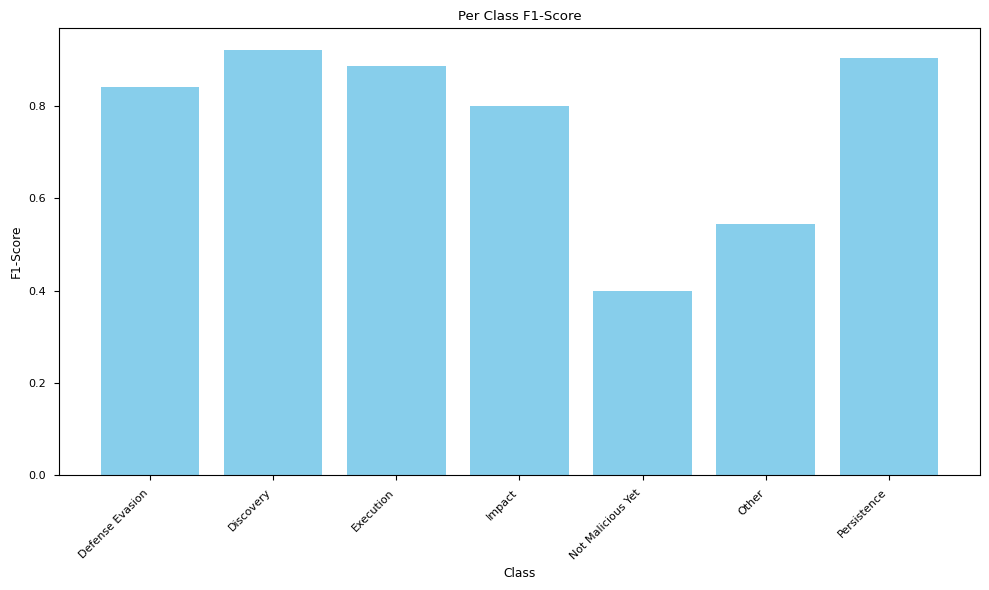

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

## Fine-tuning secure shell bert

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_secureShell["train"], shuffle=True, collate_fn=data_collator_secureShell, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_secureShell["valid"], collate_fn=data_collator_secureShell, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_secureShell["test"], collate_fn=data_collator_secureShell, batch_size=16)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path="SmartDataPolito/SecureShellBert", id2label=id2label, label2id=label2id).to(device)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.4837822183608456, 'token_f1': 0.13759408906776735}
epoch 1: {'token_accuracy': 0.6938893715609615, 'token_f1': 0.24211466841240079}
epoch 2: {'token_accuracy': 0.768462206776716, 'token_f1': 0.32534932184180704}
epoch 3: {'token_accuracy': 0.8113234868230524, 'token_f1': 0.35955254092437133}
epoch 4: {'token_accuracy': 0.8098754706052708, 'token_f1': 0.3653469004979004}
epoch 5: {'token_accuracy': 0.8530263538951637, 'token_f1': 0.38644400249041455}
epoch 6: {'token_accuracy': 0.8646104836374168, 'token_f1': 0.4687099759845794}
epoch 7: {'token_accuracy': 0.8828554879814654, 'token_f1': 0.521712960924909}
epoch 8: {'token_accuracy': 0.8795250506805676, 'token_f1': 0.5426833948208926}
epoch 9: {'token_accuracy': 0.8889371560961483, 'token_f1': 0.5837309938956695}
epoch 10: {'token_accuracy': 0.8909643788010426, 'token_f1': 0.5958601463386054}
epoch 11: {'token_accuracy': 0.8927019982623805, 'token_f1': 0.6274456419773039}
epoch 12: {'token_accuracy': 0.8977

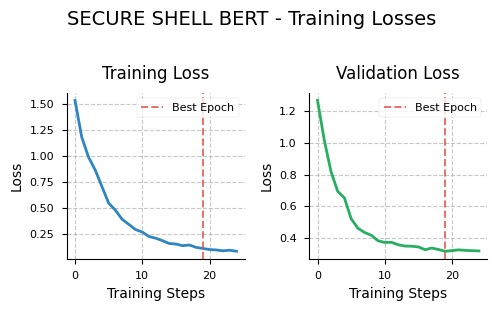

In [ ]:
learning_rate = 1e-5
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 5
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("SECURE SHELL BERT", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

### Testing

Average session fidelity: 0.85
token_accuracy      :  86.09%
token_f1            :  67.94%
token_precision     :  83.39%
token_recall        :  61.84%


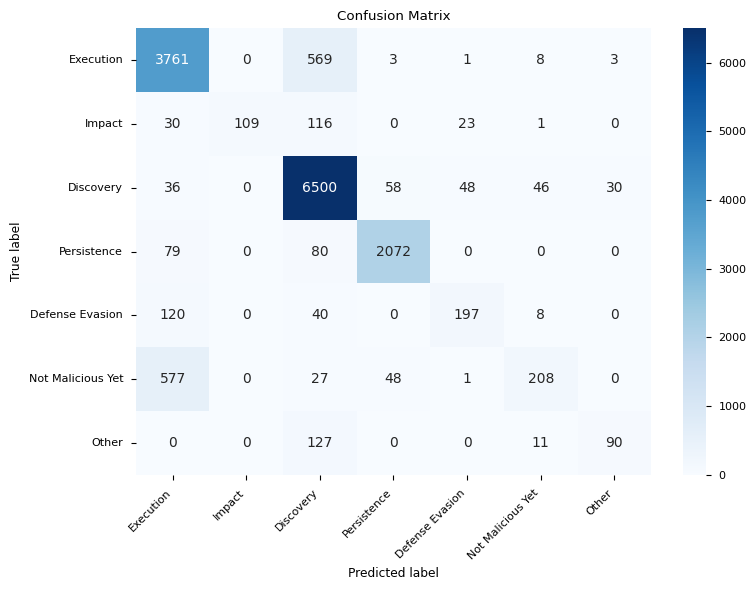

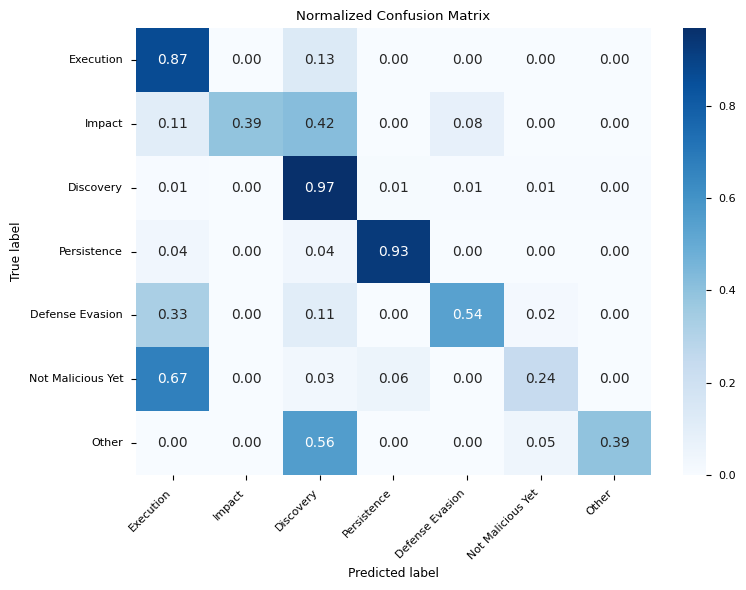

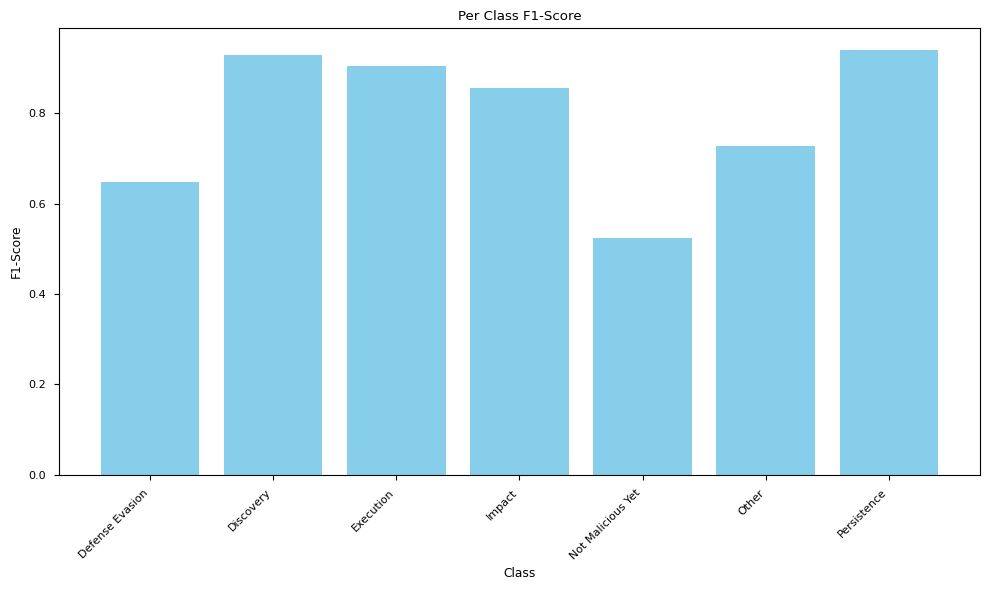

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

## Fine-tuning the best model

### Last 2 layers + classifier

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_secureShell["train"], shuffle=True, collate_fn=data_collator_secureShell, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_secureShell["valid"], collate_fn=data_collator_secureShell, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_secureShell["test"], collate_fn=data_collator_secureShell, batch_size=16)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path="SmartDataPolito/SecureShellBert", id2label=id2label, label2id=label2id).to(device)

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Full model has {total_params:,} parameters")
print(f"However, we will only train: {trainable_params:,}")


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full model has 124,060,423 parameters
However, we will only train: 14,181,127


#### Training

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.7339994207935129, 'token_f1': 0.3096251863615014}
epoch 1: {'token_accuracy': 0.7775847089487402, 'token_f1': 0.3356752950529813}
epoch 2: {'token_accuracy': 0.789748045178106, 'token_f1': 0.36734513674245234}
epoch 3: {'token_accuracy': 0.8355053576600058, 'token_f1': 0.5067446244551149}
epoch 4: {'token_accuracy': 0.8524471474080509, 'token_f1': 0.5728321568654637}
epoch 5: {'token_accuracy': 0.8753258036490009, 'token_f1': 0.665182078657815}
epoch 6: {'token_accuracy': 0.8873443382565884, 'token_f1': 0.689477961801508}
epoch 7: {'token_accuracy': 0.8871995366348103, 'token_f1': 0.7093758734315401}
epoch 8: {'token_accuracy': 0.8751810020272227, 'token_f1': 0.7137219134095943}
epoch 9: {'token_accuracy': 0.893136403127715, 'token_f1': 0.7336125756359723}
epoch 10: {'token_accuracy': 0.9119606139588763, 'token_f1': 0.7682288719863578}
epoch 11: {'token_accuracy': 0.9096437880104257, 'token_f1': 0.796940624748169}
epoch 12: {'token_accuracy': 0.92180712423

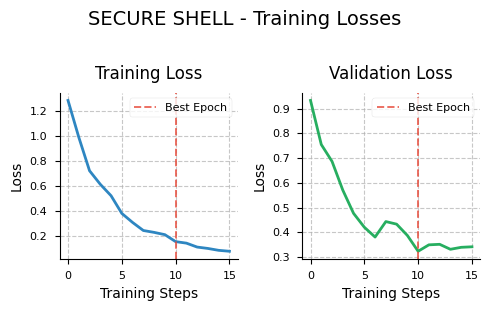

In [ ]:
learning_rate = 1e-4
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 5
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("SECURE SHELL", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

#### Testing

Average session fidelity: 0.84
token_accuracy      :  85.03%
token_f1            :  66.86%
token_precision     :  82.14%
token_recall        :  60.73%


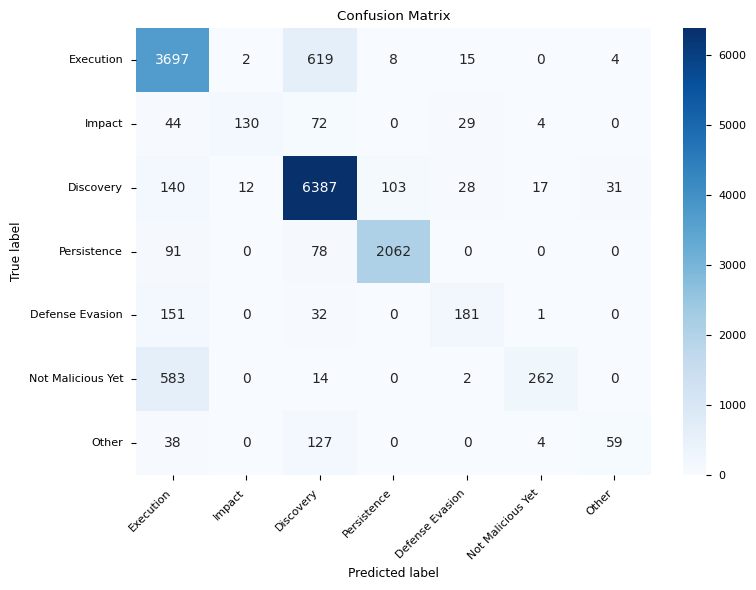

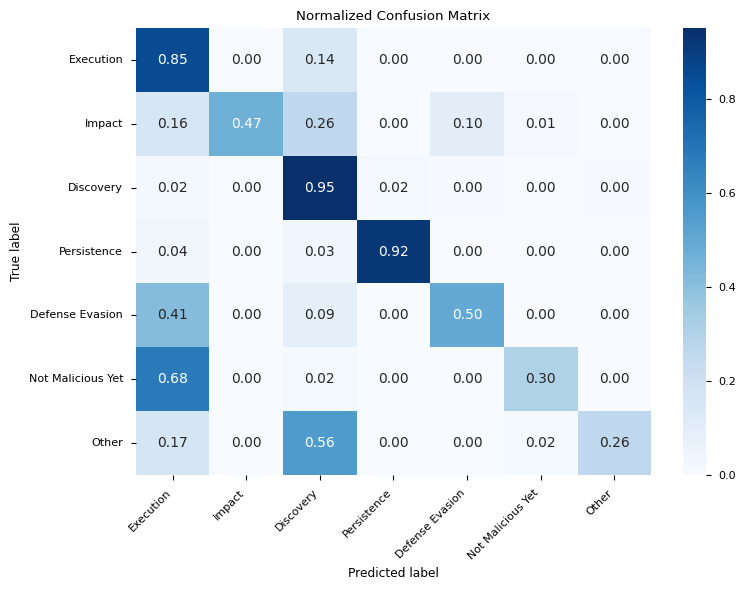

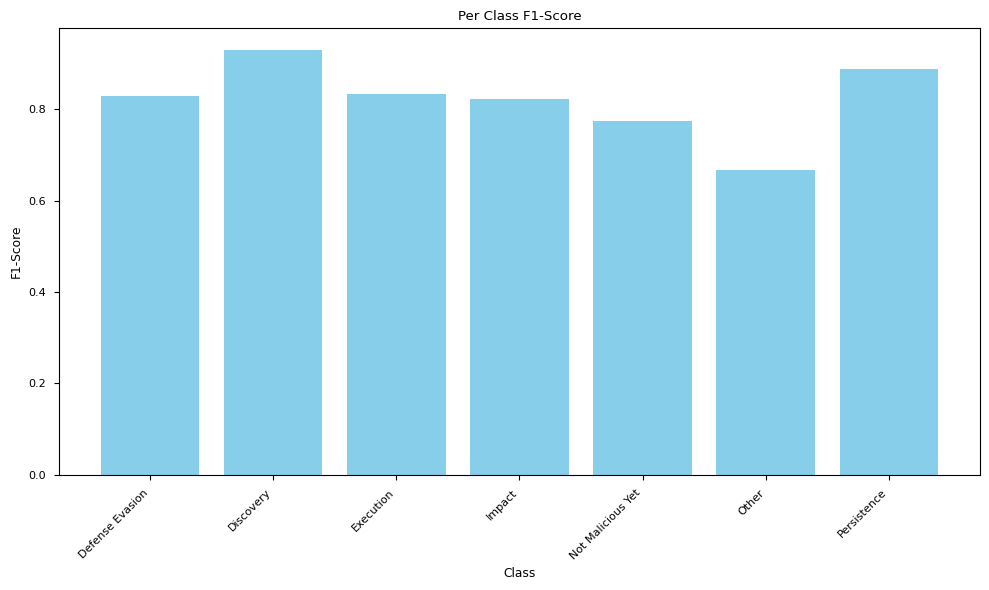

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

### Only classifier

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_secureShell["train"], shuffle=True, collate_fn=data_collator_secureShell, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_secureShell["valid"], collate_fn=data_collator_secureShell, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_secureShell["test"], collate_fn=data_collator_secureShell, batch_size=16)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path="SmartDataPolito/SecureShellBert", id2label=id2label, label2id=label2id).to(device)

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Full model has {total_params:,} parameters")
print(f"However, we will only train: {trainable_params:,}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full model has 124,060,423 parameters
However, we will only train: 5,383


#### Training

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.2435563278308717, 'token_f1': 0.10696260101822999}
epoch 1: {'token_accuracy': 0.33318853171155516, 'token_f1': 0.12293829051325532}
epoch 2: {'token_accuracy': 0.3760498117578917, 'token_f1': 0.12601520692341842}
epoch 3: {'token_accuracy': 0.4203591080220098, 'token_f1': 0.13472973858032972}
epoch 4: {'token_accuracy': 0.465537214016797, 'token_f1': 0.1468454051026116}
epoch 5: {'token_accuracy': 0.4895742832319722, 'token_f1': 0.1522086232127938}
epoch 6: {'token_accuracy': 0.5060816681146829, 'token_f1': 0.15777658681853318}
epoch 7: {'token_accuracy': 0.515928178395598, 'token_f1': 0.1609550946390884}
epoch 8: {'token_accuracy': 0.5254850854329568, 'token_f1': 0.16596062410413373}
epoch 9: {'token_accuracy': 0.5402548508543296, 'token_f1': 0.1750776580581179}
epoch 10: {'token_accuracy': 0.5503909643788011, 'token_f1': 0.18274179107295296}
epoch 11: {'token_accuracy': 0.5595134665508253, 'token_f1': 0.18751139005438247}
epoch 12: {'token_accuracy': 0.

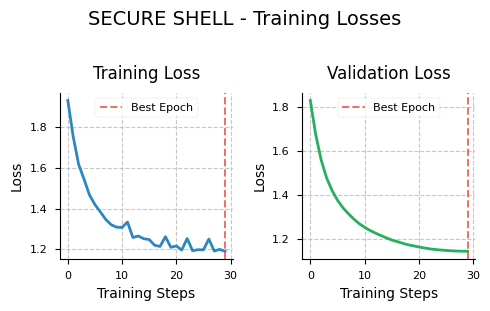

In [ ]:
learning_rate = 1e-4
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 5
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("SECURE SHELL", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

#### Testing

Average session fidelity: 0.52
token_accuracy      :  57.25%
token_f1            :  21.15%
token_precision     :  25.84%
token_recall        :  22.54%


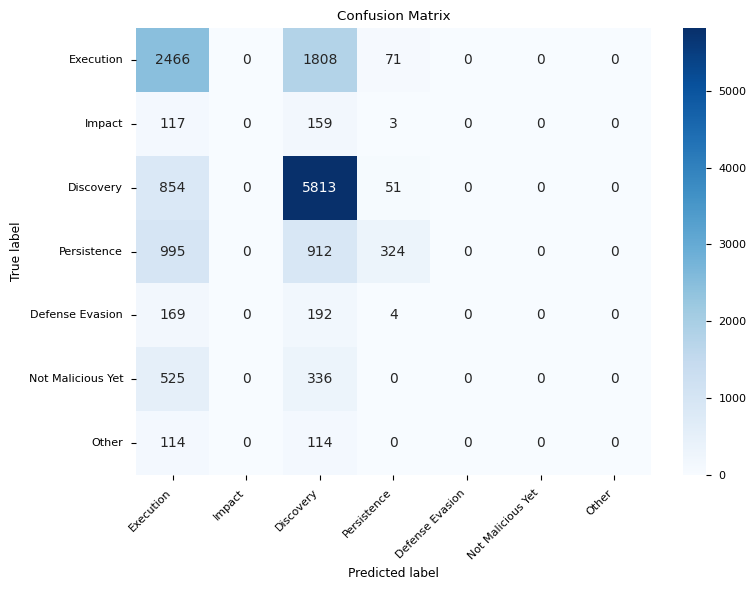

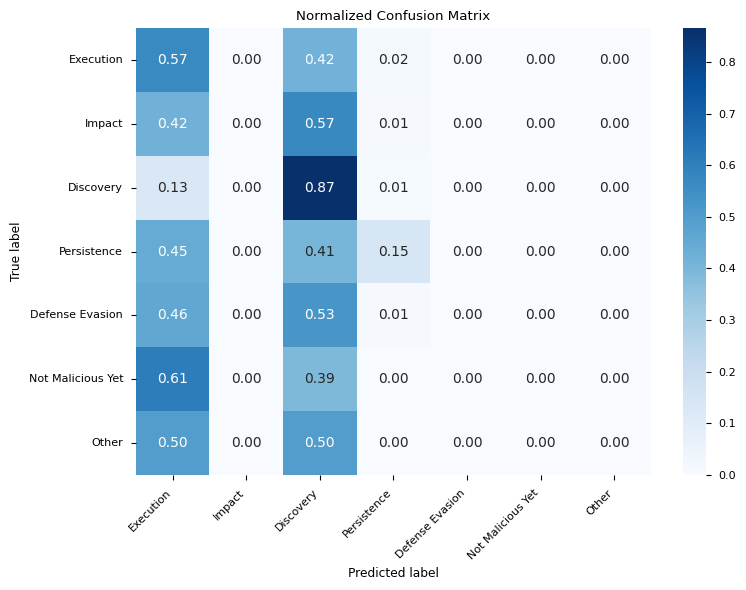

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


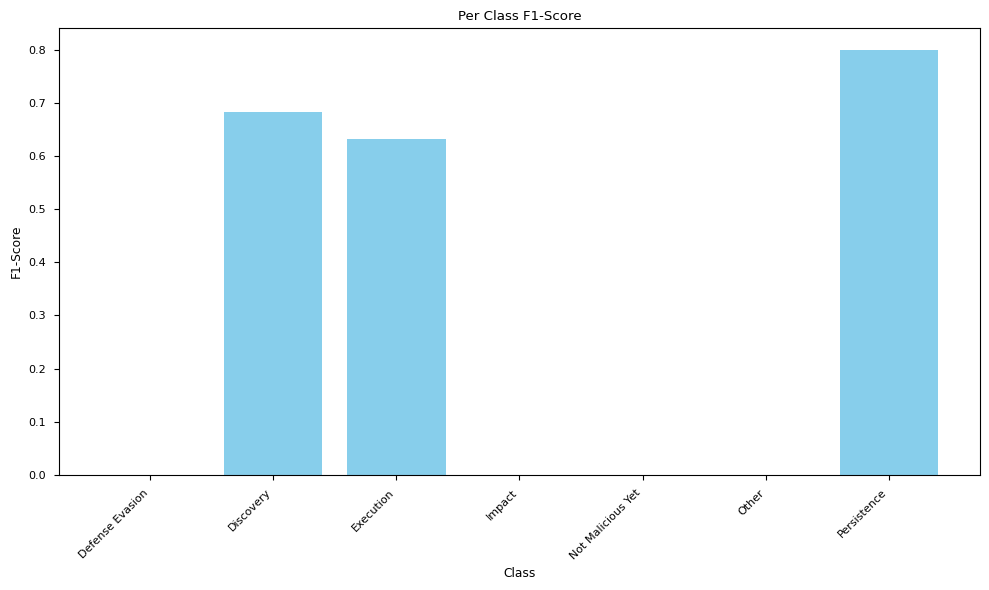

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

# Task 4: Inference

## Training the best model

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5933970460469157, 'token_f1': 0.1891854439724932}
epoch 1: {'token_accuracy': 0.6727483347813495, 'token_f1': 0.21674822041962935}
epoch 2: {'token_accuracy': 0.7329858094410657, 'token_f1': 0.28660910514204757}
epoch 3: {'token_accuracy': 0.8039386041123661, 'token_f1': 0.35516041799716364}
epoch 4: {'token_accuracy': 0.8430350419924704, 'token_f1': 0.37764952785400674}
epoch 5: {'token_accuracy': 0.8611352447147408, 'token_f1': 0.4050176626215357}
epoch 6: {'token_accuracy': 0.8741673906747756, 'token_f1': 0.4979876261231565}
epoch 7: {'token_accuracy': 0.8840139009556907, 'token_f1': 0.5239924746752321}
epoch 8: {'token_accuracy': 0.8760498117578916, 'token_f1': 0.5493939967632969}
epoch 9: {'token_accuracy': 0.8870547350130321, 'token_f1': 0.5863059438477418}
epoch 10: {'token_accuracy': 0.8919779901534897, 'token_f1': 0.6138344383873446}
epoch 11: {'token_accuracy': 0.896611642050391, 'token_f1': 0.6341099685218239}
epoch 12: {'token_accuracy': 0.9106

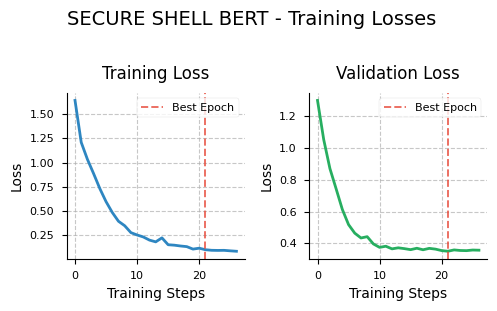

Average session fidelity: 0.82
token_accuracy      :  84.95%
token_f1            :  62.93%
token_precision     :  78.78%
token_recall        :  57.29%


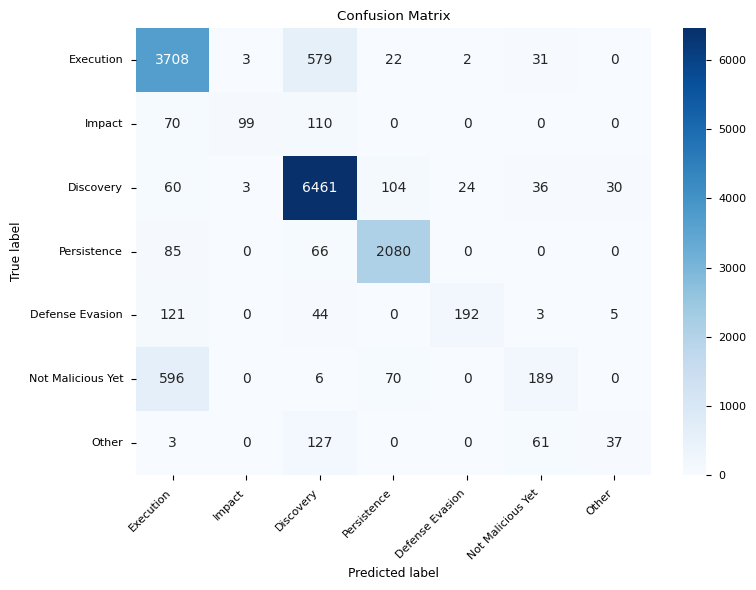

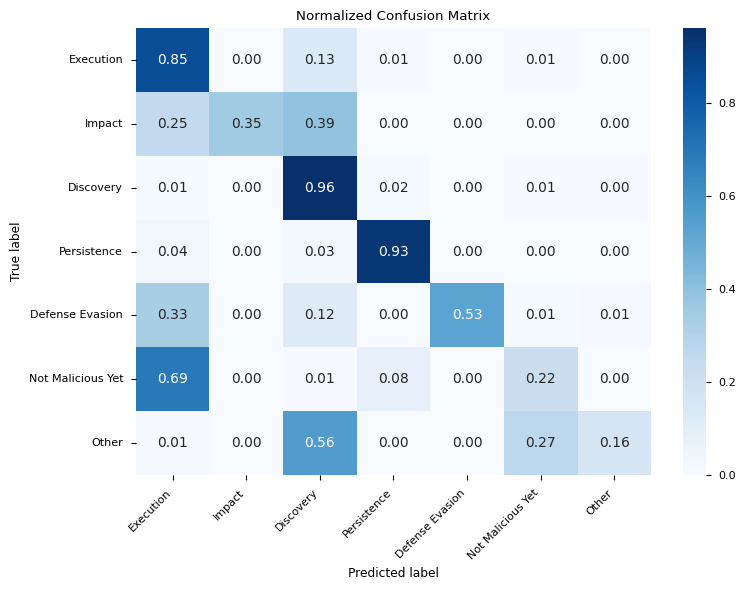

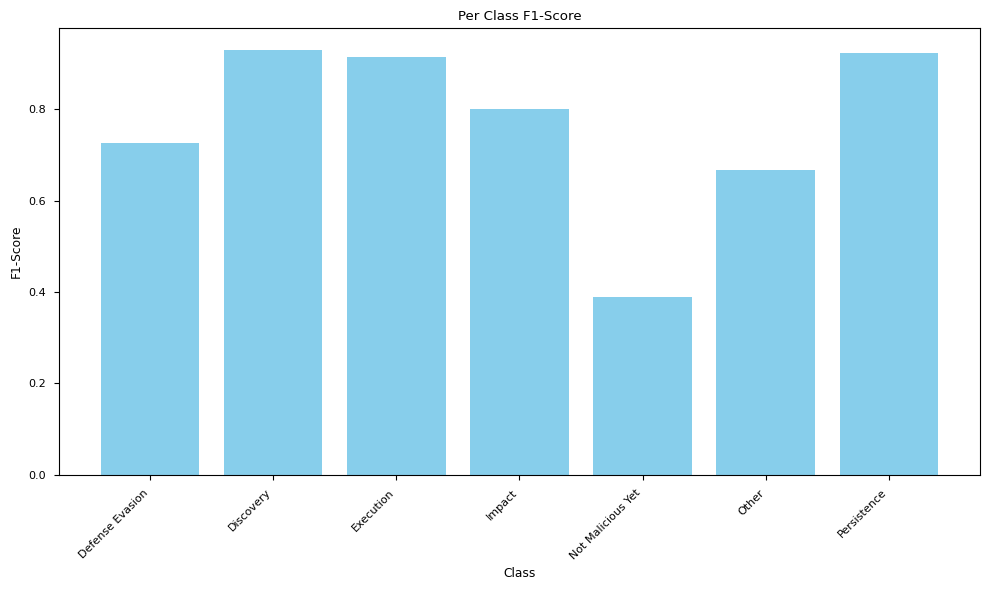

In [ ]:
train_dataloader = DataLoader(tokenized_datasets_secureShell["train"], shuffle=True, collate_fn=data_collator_secureShell, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets_secureShell["valid"], collate_fn=data_collator_secureShell, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets_secureShell["test"], collate_fn=data_collator_secureShell, batch_size=16)

# Loading the pretrained model
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path="SmartDataPolito/SecureShellBert", id2label=id2label, label2id=label2id).to(device)

learning_rate = 1e-5
epochs = 30
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

# Early‑stopping params
patience = 5
no_improve_counter = 0

# Start global timer
total_start = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in val_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(val_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss < best_val_loss - 1e-4:   # use a small delta to avoid noise
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
            break

total_time = time.time() - total_start
print(f"Total training time: {total_time:.2f} seconds")

plot_stats("SECURE SHELL BERT", train_losses, validation_losses=val_losses, best_epoch=best_epoch)

# Evaluation
model.eval()
full_predictions, full_labels = [], []
fidelity_scores = []  # List to store fidelity scores for each session

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions += true_predictions
    full_labels += true_labels

    # Calculate fidelity scores for each session
    for pred, label in zip(true_predictions, true_labels):
        correct_predictions = sum(p == l for p, l in zip(pred, label))
        session_fidelity = correct_predictions / len(label)
        fidelity_scores.append(session_fidelity)

# Calculate the average fidelity
average_fidelity = sum(fidelity_scores) / len(fidelity_scores)
print(f"Average session fidelity: {average_fidelity:.2f}")

test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)
plot_f1_score_per_label(full_labels, full_predictions)

In [ ]:
def tokenize_and_align_labels(samples, tokenizer):
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True,  # Input is already split into words
        max_length=512
    )
    return tokenized_inputs

# Import inference dataset
inference_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab_3/cyberlab.csv")

# Truncate the words to 30 character to avoid generate more tokens than the context size of bert
inference_data = pd.DataFrame({
    "session": [" ".join(word[:30] for word in session.split(" ")) for session in inference_data['session']],
    "timestamp": inference_data['timestamps_statements'],
})

inference_data = DatasetDict(
    {
        "inference": Dataset.from_pandas(inference_data.reset_index(drop=True)),
    }
)

tokenized_data_secureShell = inference_data.map(
    lambda samples: tokenize_and_align_labels(samples, secureShell_tokenizer),
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=inference_data["inference"].column_names, # To remove the original columns
)

Map:   0%|          | 0/174262 [00:00<?, ? examples/s]

In [ ]:
def postprocess_without_labels(predictions, input_ids):
    # Detach and move predictions and input_ids to CPU for processing
    predictions = predictions.detach().cpu().clone().numpy()
    input_ids = input_ids.detach().cpu().clone().numpy()

    word_predictions = []
    for input_ids_batch, prediction_batch in zip(input_ids, predictions):
        tokens = secureShell_tokenizer.convert_ids_to_tokens(input_ids_batch)
        words = []
        word_labels = []
        current_word = ""
        current_label = None

        for token, label_id in zip(tokens, prediction_batch):
            # Start of a new word (indicated by a special word boundary character like Ġ)
            if token.startswith("Ġ"):
                if current_word:  # Finalize the current word
                    words.append(current_word)
                    word_labels.append(current_label)  # Assign the label of the first token
                # Start a new word
                current_word = token[1:]
                current_label = id2label[label_id]  # Extract label from the first token
            elif token.startswith("<") and token.endswith(">"):  # Skip special tokens
                continue
            else:
                current_word += token  # Append subword to current word

        # Finalize the last word if necessary
        if current_word:
            words.append(current_word)
            word_labels.append(current_label)

        # Store word-to-label mappings for the batch
        word_predictions.append({"words": words, "labels": word_labels})

    return word_predictions

inference_dataloader = DataLoader(tokenized_data_secureShell["inference"], collate_fn=data_collator_secureShell, batch_size=16)

# Evaluation
model.eval()
full_predictions = []

for batch in inference_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Pass the batch to the model
        outputs = best_model(**batch)

    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    predictions_with_words = postprocess_without_labels(predictions, batch["input_ids"])
    full_predictions += predictions_with_words

# Print example predictions with tokens and their corresponding tags
print("Mappings between words and predicted labels:")
for example in full_predictions[:5]:  # Display only first 5 examples for clarity
    for word, label in zip(example["words"], example["labels"]):
        print(f"{word} -> {label}")
    print("\n")

Mappings between words and predicted labels:
enable -> Discovery
; -> Discovery
system -> Discovery
; -> Discovery
shell -> Discovery
; -> Discovery
sh -> Discovery
; -> Discovery
cat -> Discovery
/proc/mounts; -> Discovery
/bin/busybox -> Discovery
TIPZU -> Discovery
; -> Discovery
cd -> Discovery
/dev/shm; -> Discovery
cat -> Discovery
.s -> Discovery
|| -> Discovery
cp -> Discovery
/bin/echo -> Discovery
.s; -> Discovery
/bin/busybox -> Discovery
TIPZU -> Discovery
; -> Discovery
tftp; -> Discovery
wget; -> Discovery
/bin/busybox -> Discovery
TIPZU -> Discovery
; -> Discovery
dd -> Discovery
bs=52 -> Discovery
count=1 -> Discovery
if=.s -> Discovery
|| -> Discovery
cat -> Discovery
.s -> Discovery
|| -> Discovery
while -> Discovery
read -> Discovery
i; -> Discovery
do -> Discovery
echo -> Discovery
$i; -> Discovery
done -> Discovery
< -> Discovery
.s -> Discovery
; -> Discovery
/bin/busybox -> Discovery
TIPZU -> Discovery
; -> Discovery
rm -> Discovery
.s; -> Discovery
exit -> Disco

## Frequency of predicted tags

In [ ]:
filter_words = {"cat", "grep", "echo", "rm"}
filtered_results = [
    (word, label) for example in full_predictions  # Iterate over relevant predictions
    for word, label in zip(example["words"], example["labels"])
    if word in filter_words
]

word_label_frequencies = []

for word in filter_words:
    word_labels = [label for w, label in filtered_results if w == word]
    word_label_frequencies.append({
        "Word": word,
        "Label Frequencies": dict(Counter(word_labels))
    })

# Create a PrettyTable for a fancy display
table = PrettyTable()
table.field_names = ["Word", "Label Frequencies"]

for word_data in word_label_frequencies:
    table.add_row([word_data["Word"], word_data["Label Frequencies"]])

# Show the table
print(table)

+------+-----------------------------------------------------------------------------------------------------------+
| Word |                                             Label Frequencies                                             |
+------+-----------------------------------------------------------------------------------------------------------+
|  rm  |          {'Discovery': 260988, 'Defense Evasion': 6825, 'Execution': 71374, 'Persistence': 5453}          |
| echo | {'Discovery': 228551, 'Persistence': 353003, 'Execution': 176433, 'Other': 1613, 'Not Malicious Yet': 74} |
| grep |                                 {'Discovery': 995999, 'Persistence': 375}                                 |
| cat  |                                  {'Discovery': 861281, 'Execution': 247}                                  |
+------+-----------------------------------------------------------------------------------------------------------+


## Example session for each tuple

In [ ]:
filter_words = {"cat", "grep", "echo", "rm"}
examples_for_words = {}

# Find one example session per (word, label) tuple for the filtered words
for example in full_predictions:
    for word, label in zip(example["words"], example["labels"]):
        if word in filter_words and (word, label) not in examples_for_words:
            examples_for_words[(word, label)] = " ".join(f"{w} ({l})" if w in filter_words else f"{w}" for w, l in zip(example["words"], example["labels"]))

# Create and display table
table = PrettyTable()
table.field_names = ["Word", "Label", "Example Session"]

for (word, label), session in sorted(examples_for_words.items()):
    table.add_row([word, label, session])

print(table)

+------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Find unique fingerprints

In [ ]:
# Add timestamp column to full_predictions and process as requested
unique_fingerprints = pd.DataFrame(full_predictions)
unique_fingerprints['timestamp'] = inference_data['inference']['timestamp']

# Sort per timestamp
unique_fingerprints = unique_fingerprints.sort_values('timestamp', ascending=True)

# Remove rows with duplicate 'labels' values
unique_fingerprints = unique_fingerprints.drop_duplicates(subset=['labels'])

# Reset the DataFrame indexes after dropping duplicates
unique_fingerprints = unique_fingerprints.reset_index(drop=True)

# Remove "words" and "timestamp" column
unique_fingerprints = unique_fingerprints.drop(columns=['words', 'timestamp'])

# Add an index column for each row
unique_fingerprints['fingerprint_id'] = unique_fingerprints.index

unique_fingerprints = unique_fingerprints.rename(columns={'labels':'fingerprint'})
unique_fingerprints

,fingerprint,fingerprint_id
0,"[Discovery, Discovery, Discovery, Discovery, D...",0
1,"[Discovery, Discovery, Discovery, Discovery, D...",1
2,"[Not Malicious Yet, Not Malicious Yet, Not Mal...",2
3,"[Execution, Execution, Execution, Execution, E...",3
4,"[Discovery, Discovery, Discovery, Discovery, D...",4
...,...,...
4855,"[Discovery, Discovery, Discovery, Discovery, D...",4855
4856,"[Discovery, Discovery, Discovery, Discovery, D...",4856
4857,"[Discovery, Discovery, Discovery, Discovery, D...",4857
4858,"[Discovery, Discovery, Discovery, Discovery, D...",4858


In [ ]:
inference_data_df = pd.DataFrame(inference_data['inference'])
inference_data_df['timestamp'] = inference_data_df['timestamp'].str[:10]

full_predictions_df = pd.DataFrame(full_predictions)
full_predictions_df['date'] = inference_data_df['timestamp']

session_per_day = full_predictions_df.groupby("date").agg(list).reset_index()

In [ ]:
print(len(session_per_day))

print(len(unique_fingerprints))

print(len(full_predictions))

118
4860
174262


## Plot the results

In [ ]:
# 1) Build the dictionary (hashtable) using tuple(fp) as the key.
# This dictionary allows fast O(1) lookups using hashed keys (fingerprints).
mapping = {
    tuple(fp): fid  # Each tuple(fp) is hashed using Python's hash() and stored in the hashtable.
    for fp, fid in zip(
        unique_fingerprints['fingerprint'],  # Extract the fingerprint column (lists)
        unique_fingerprints['fingerprint_id']  # Extract the fingerprint_id column
    )
}

# 2) Define a function to map each list of labels to their corresponding fingerprint IDs.
def map_labels(label_list):
    # For each label in the list, convert it to a tuple (hashable) and look it up in the hashtable (O(1) lookup).
    return [int(mapping[tuple(lbl)]) for lbl in label_list]

# 3) Apply the mapping function to each list of labels in the 'labels' column of session_per_day.
# The apply() method efficiently loops through each row, leveraging the fast hashtable lookup for each label.
session_per_day['labels'] = session_per_day['labels'].apply(map_labels)


In [ ]:
session_per_day

,date,words,labels
0,2019-09-01,"[[enable, ;, system, ;, shell, ;, sh, ;, cat, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2019-09-02,"[[enable, ;, system, ;, shell, ;, sh, ;, cat, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2019-09-03,"[[enable, ;, system, ;, shell, ;, sh, ;, cat, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 3, 0, 0, 0, 0, ..."
3,2019-09-04,"[[enable, ;, system, ;, shell, ;, sh, ;, cat, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2019-09-06,"[[cat, /proc/cpuinfo, |, grep, name, |, wc, -l...","[10, 1, 10, 0, 0, 1, 20, 0, 20, 0, 0, 0, 20, 0..."
...,...,...,...
113,2019-12-26,"[[cat, /proc/cpuinfo, |, grep, name, |, wc, -l...","[4807, 781, 108, 4807, 4807, 1213, 300, 4807, ..."
114,2019-12-27,"[[cat, /proc/cpuinfo, |, grep, name, |, wc, -l...","[4807, 1160, 137, 4807, 4844, 123, 156, 4807, ..."
115,2019-12-28,"[[cat, /proc/cpuinfo, |, grep, name, |, wc, -l...","[4807, 4807, 4807, 4807, 4807, 156, 4851, 108,..."
116,2019-12-29,"[[cat, /proc/cpuinfo, |, grep, name, |, wc, -l...","[4807, 4807, 4807, 229, 125, 4807, 4807, 4807,..."


In [ ]:
label_counts_per_day = session_per_day['labels'].apply(lambda label_list: pd.Series(label_list).value_counts().to_dict())
session_per_day['label_counts'] = label_counts_per_day

In [ ]:
scatter_data = []
for _, row in session_per_day.iterrows():
    date = row['date']
    label_counts = row['label_counts']
    for label_id, count in label_counts.items():
        scatter_data.append((date, label_id, count))

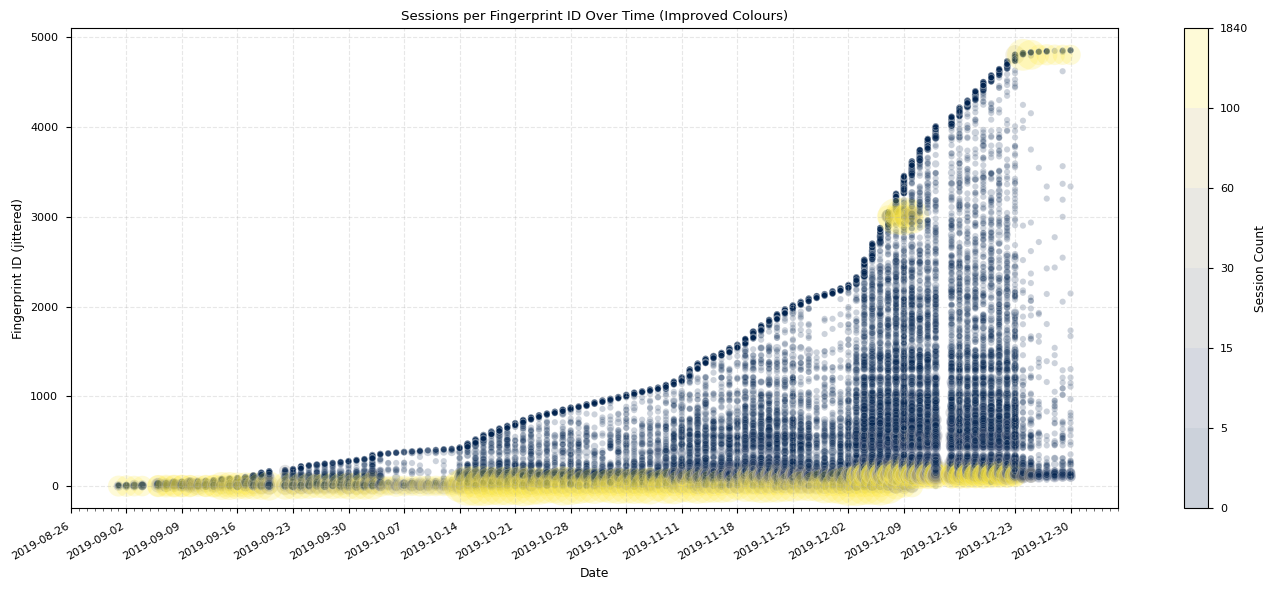

In [ ]:
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

dates, fingerprints, counts = zip(*scatter_data)
dates = pd.to_datetime(dates)
order = np.argsort(dates)
dates = dates[order]
fingerprints = np.array(fingerprints)[order]
counts = np.array(counts)[order]

jitter = np.random.normal(scale=0.1, size=len(fingerprints))
fingerprints_j = fingerprints + jitter

cmap = plt.get_cmap('cividis')

bins = [0, 5, 15, 30, 60, 100, counts.max()]
norm = mcolors.BoundaryNorm(bins, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(14, 6))
sc = ax.scatter(
    dates,
    fingerprints_j,
    s=np.sqrt(counts) * 20,      # marker area ~ √count
    c=counts,                    # raw counts
    cmap=cmap,
    norm=norm,                   # use discrete bins (remove if you want continuous)
    alpha=0.2,
    edgecolors='w',              # white border for better separation
    linewidth=0.3
)

cbar = fig.colorbar(sc, ax=ax, boundaries=bins, ticks=bins)
cbar.set_label('Session Count')
cbar.ax.set_yticklabels([str(b) for b in bins])

ax.grid(True, linestyle='--', alpha=0.3)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(which='major'), rotation=30, ha='right')

ax.set_xlabel("Date")
ax.set_ylabel("Fingerprint ID (jittered)")
ax.set_title("Sessions per Fingerprint ID Over Time (Improved Colours)")

plt.tight_layout()
plt.show()